In [114]:
#Used for displaying plots below the cell, inverts %matplotlib inline
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sn
import itertools
import dalex as dx

#Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import base

from sklearn.cluster import AgglomerativeClustering

#Models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from wittgenstein import RIPPER
from sklearn.neural_network import MLPClassifier

#Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, learning_curve, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, \
    classification_report, plot_roc_curve

#visualize the decision tree obtained 
import pydotplus 
from IPython.display import Image

from imblearn.over_sampling import SMOTE

import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions

In [2]:
vendor_df_num = pd.read_csv('./task1-result_num_wo_out.csv', sep=',', index_col=[0,1])
vendor_df_cat = pd.read_csv('./task1-result_cat_wo_out.csv', sep=',', index_col=[0,1])

#Used for retrieving the outliers from task 1
vendor_df_num_w_out = pd.read_csv('./task1-result_num_w_out.csv', sep=',', index_col=[0,1])
vendor_df_cat_w_out = pd.read_csv('./task1-result_cat_w_out.csv', sep=',', index_col=[0,1])

df_ram = pd.read_csv('./ram.csv', sep=',', index_col=0)
df_geo = pd.read_csv('./geography.csv', sep=',', index_col=0)

## Categorical features discretisation

In [3]:
vendor_df_cat_discr = vendor_df_cat.copy()
vendor_df_cat_discr_w_out = vendor_df_cat_w_out.copy()

### TopBrand

In [4]:
vendor_df_cat_discr.head()

TopBrand                TopCountry  \
vendor_code name                                                       
1           1stWave Technologies   CORSAIR                New Zeland   
2           Adorama                CRUCIAL  United States of America   
3           Alternate              G.SKILL                    France   
4           Alternate Italia       G.SKILL                     Italy   
5           Alza                  KINGSTON            United Kingdom   

                                 TopCurrency  TopSalesMonth  
vendor_code name                                             
1           1stWave Technologies         NZD             11  
2           Adorama                      USD              4  
3           Alternate                    EUR              3  
4           Alternate Italia             EUR              3  
5           Alza                         GBP             12

In [5]:
brand_names = sorted(df_ram["brand"].unique())
brand_map = dict(zip(brand_names, range(len(brand_names))))

vendor_df_cat_discr.loc[:, "TopBrand"] = vendor_df_cat_discr["TopBrand"].transform(lambda x, feat_map=brand_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopBrand"] = vendor_df_cat_discr_w_out["TopBrand"].transform(lambda x, feat_map=brand_map: feat_map[x])

### TopCountry

In [6]:
vendor_df_cat_discr.head()

TopBrand                TopCountry  \
vendor_code name                                                       
1           1stWave Technologies         9                New Zeland   
2           Adorama                     10  United States of America   
3           Alternate                   17                    France   
4           Alternate Italia            17                     Italy   
5           Alza                        30            United Kingdom   

                                 TopCurrency  TopSalesMonth  
vendor_code name                                             
1           1stWave Technologies         NZD             11  
2           Adorama                      USD              4  
3           Alternate                    EUR              3  
4           Alternate Italia             EUR              3  
5           Alza                         GBP             12

In [7]:
country_names = sorted(df_geo["country"].unique())
country_map = dict(zip(country_names, range(len(country_names))))

vendor_df_cat_discr.loc[:, "TopCountry"] = vendor_df_cat_discr["TopCountry"].transform(lambda x, feat_map=country_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopCountry"] = \
        vendor_df_cat_discr_w_out["TopCountry"].transform(lambda x, feat_map=country_map: feat_map[x])

### TopCurrency

In [8]:
vendor_df_cat_discr.head()

TopBrand  TopCountry TopCurrency  \
vendor_code name                                                     
1           1stWave Technologies         9           7         NZD   
2           Adorama                     10          10         USD   
3           Alternate                   17           3         EUR   
4           Alternate Italia            17           6         EUR   
5           Alza                        30           9         GBP   

                                  TopSalesMonth  
vendor_code name                                 
1           1stWave Technologies             11  
2           Adorama                           4  
3           Alternate                         3  
4           Alternate Italia                  3  
5           Alza                             12

In [9]:
currency_names = sorted(df_geo["currency"].unique())
currency_map = dict(zip(currency_names, range(len(currency_names))))

vendor_df_cat_discr.loc[:, "TopCurrency"] = vendor_df_cat_discr["TopCurrency"].transform(lambda x, feat_map=currency_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopCurrency"] = \
        vendor_df_cat_discr_w_out["TopCurrency"].transform(lambda x, feat_map=currency_map: feat_map[x])

### TopSalesMonth

In [10]:
vendor_df_cat_discr.head()

TopBrand  TopCountry  TopCurrency  \
vendor_code name                                                      
1           1stWave Technologies         9           7            4   
2           Adorama                     10          10            5   
3           Alternate                   17           3            2   
4           Alternate Italia            17           6            2   
5           Alza                        30           9            3   

                                  TopSalesMonth  
vendor_code name                                 
1           1stWave Technologies             11  
2           Adorama                           4  
3           Alternate                         3  
4           Alternate Italia                  3  
5           Alza                             12

Already expressed in numerical values, ready to be normalised.

## Normalisation

In [11]:
vend_scaler = MinMaxScaler()
vend_scaler.fit(vendor_df_num.values)
vendor_norm = vend_scaler.transform(vendor_df_num.values)
vendor_df_norm = pd.DataFrame(vendor_norm, columns=vendor_df_num.columns, index=vendor_df_num.index)

## Define big-seller/small-seller label

In [12]:
vendor_df_num.head()

I   Iu  MaxValuePerOrder  \
vendor_code name                                                 
1           1stWave Technologies    774   60        565.439098   
2           Adorama                3274  186       1761.990000   
3           Alternate              3047  203        860.154236   
4           Alternate Italia        407  101        774.077840   
5           Alza                  12959  276       1188.115658   

                                  AvgValuePerOrder  AvgMemoryPerOrder  \
vendor_code name                                                        
1           1stWave Technologies        132.989886          13.074935   
2           Adorama                     146.248003          14.628894   
3           Alternate                   155.134195          11.530030   
4           Alternate Italia            142.140184          10.034398   
5           Alza                        166.036705          13.514777   

                                  IAvgMonthSales  TotMonthBusiness      Eram  \
vendor_code name                                                               
1           1stWave Technologies     4117.366865                25  5.361843   
2           Adorama                 23940.798168                20  6.754711   
3           Alternate              157564.631150                 3  7.373634   
4           Alternate Italia        28925.527422                 2  6.486558   
5           Alza                   126568.803904                17  7.612859   

                                      Egeo      Ecur  
vendor_code name                                      
1           1stWave Technologies  0.643988  0.643988  
2           Adorama               0.000000  0.000000  
3           Alternate             1.679995  0.000000  
4           Alternate Italia      0.898296  0.898296  
5           Alza                  1.165894  1.094659

What defines a seller as big?  
We will take inspiration from the clustering results and define the **big-seller/small-seller** labels by using the **I/IAvgMonthSales** features.  

In [13]:
clust_labels = AgglomerativeClustering(n_clusters=2, linkage="average").fit(vendor_norm).labels_
clust_labels_df = vendor_df_num.copy()
clust_labels_df.loc[:, "Label"] = -1

for i in range(len(clust_labels)):
    
    if clust_labels[i] == 0:
        clust_labels_df.iloc[i, -1] = "small-seller"
    else:
        clust_labels_df.iloc[i, -1] = "big-seller"

In [14]:
clust_labels_df.loc[clust_labels_df["Label"] == "small-seller"].max()

I                            27633
Iu                             680
MaxValuePerOrder       3195.875774
AvgValuePerOrder        499.458429
AvgMemoryPerOrder        30.890521
IAvgMonthSales       354101.045624
TotMonthBusiness                25
Eram                      9.006487
Egeo                      1.679995
Ecur                      1.522173
Label                 small-seller
dtype: object

In [15]:
clust_labels_df.loc[clust_labels_df["Label"] == "big-seller"].min()

I                            39137
Iu                             393
MaxValuePerOrder       1839.953682
AvgValuePerOrder        152.947845
AvgMemoryPerOrder        14.982037
IAvgMonthSales       284764.654091
TotMonthBusiness                23
Eram                      7.960206
Egeo                           0.0
Ecur                           0.0
Label                   big-seller
dtype: object

Unfortunately, if we were to perfectly adhere to the clustering results, the number of samples in the **big-seller** label is too low to perform any meaningful predictive analysis.  
We will therefore expand the meaning of **big-seller**, currently dominated by the **I** feature (note the min and max of **I** for each label), to also include entries that have a relatively low **I** but a high **IAvgSalesMonth** value.

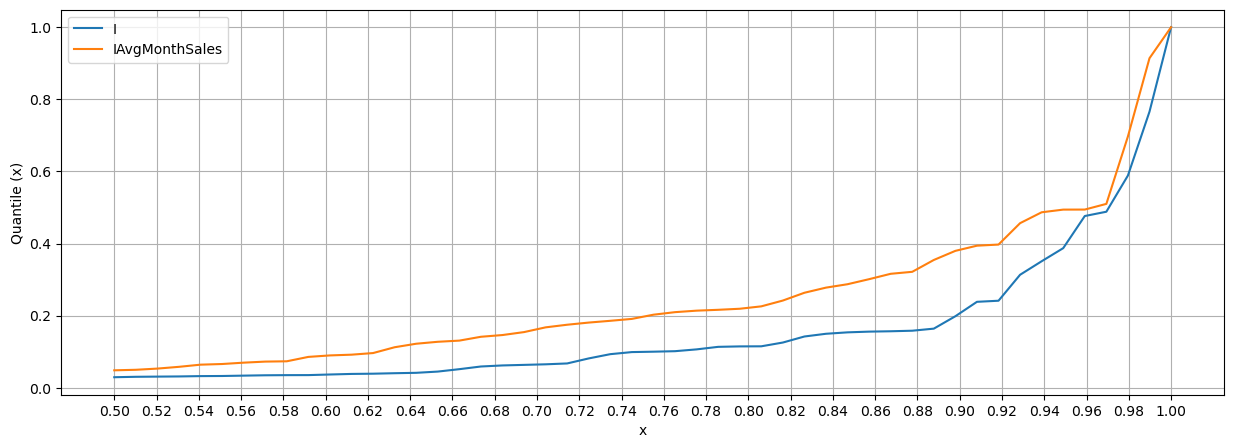

In [16]:
key_features = ["I", "IAvgMonthSales"]
pred_label_df = vendor_df_norm.copy()

pred_label_df[key_features].quantile(np.linspace(0.5, 1, 50)).plot(figsize=(15,5), grid=True)
plt.xlabel("x")
plt.ylabel("Quantile (x)")
plt.xticks(np.arange(0.5, 1.02, 0.02))
plt.show()

In [17]:
pred_label_df["Label"] = "small-seller"

pred_label_df.loc[pred_label_df["I"] >= pred_label_df["I"].quantile(0.80), "Label"] = "big-seller"
pred_label_df.loc[pred_label_df["IAvgMonthSales"] >= pred_label_df["IAvgMonthSales"].quantile(0.90), "Label"] = "big-seller"

pred_label_df.groupby("Label").size()

Label
big-seller      16
small-seller    59
dtype: int64

We decide to go with:
- big-seller: any entry having **I** >= quantile(0.8) or **IAvgMonthSales** >= quantile(0.8) of the whole dataset
- small-seller: everything else

We decided to go for this definition based on the above plot, in which the values of these features start to take off (forming a knee) around that value.  
This definition doubles the amount of data points that we have to work with when it comes to the **big-seller** label.

In [18]:
small_seller_df_norm = pred_label_df.loc[pred_label_df["Label"] == "small-seller"]
small_seller_df_norm.describe()

I         Iu  MaxValuePerOrder  AvgValuePerOrder  \
count  59.000000  59.000000         59.000000         59.000000   
mean    0.027195   0.112363          0.160053          0.264247   
std     0.028808   0.096034          0.121216          0.222967   
min     0.000000   0.000000          0.000000          0.000000   
25%     0.005920   0.036977          0.063853          0.122839   
50%     0.018712   0.088424          0.124713          0.172221   
75%     0.035073   0.165997          0.259288          0.347845   
max     0.113253   0.543408          0.492266          1.000000   

       AvgMemoryPerOrder  IAvgMonthSales  TotMonthBusiness       Eram  \
count          59.000000       59.000000         59.000000  59.000000   
mean            0.361157        0.068316          0.595339   0.518504   
std             0.211379        0.085802          0.380786   0.205527   
min             0.000000        0.000000          0.000000   0.000000   
25%             0.209956        0.012075          0.208333   0.416818   
50%             0.320440        0.038242          0.666667   0.566039   
75%             0.476771        0.080837          1.000000   0.672809   
max             1.000000        0.368735          1.000000   0.899448   

            Egeo       Ecur  
count  59.000000  59.000000  
mean    0.292167   0.259680  
std     0.204815   0.218184  
min     0.000000   0.000000  
25%     0.192710   0.000000  
50%     0.328149   0.300021  
75%     0.368002   0.394126  
max     1.000000   1.000000

In [19]:
big_seller_df_norm = pred_label_df.loc[pred_label_df["Label"] == "big-seller"]
big_seller_df_norm.describe()

I         Iu  MaxValuePerOrder  AvgValuePerOrder  \
count  16.000000  16.000000         16.000000         16.000000   
mean    0.312479   0.408762          0.336851          0.248761   
std     0.247203   0.257505          0.242397          0.120629   
min     0.114889   0.165595          0.153306          0.127989   
25%     0.154051   0.225683          0.164017          0.179757   
50%     0.202028   0.303457          0.291883          0.211621   
75%     0.390255   0.481310          0.324304          0.292474   
max     1.000000   1.000000          1.000000          0.639707   

       AvgMemoryPerOrder  IAvgMonthSales  TotMonthBusiness       Eram  \
count          16.000000       16.000000         16.000000  16.000000   
mean            0.431251        0.397517          0.882812   0.782936   
std             0.095910        0.251342          0.180161   0.117875   
min             0.308643        0.129627          0.500000   0.644442   
25%             0.362183        0.210666          0.864583   0.682351   
50%             0.405553        0.357635          1.000000   0.759081   
75%             0.503459        0.494118          1.000000   0.892422   
max             0.607392        1.000000          1.000000   1.000000   

            Egeo       Ecur  
count  16.000000  16.000000  
mean    0.299745   0.303996  
std     0.127232   0.160005  
min     0.000000   0.000000  
25%     0.264957   0.291278  
50%     0.351979   0.385131  
75%     0.386953   0.426001  
max     0.390736   0.431248

## Feature correlations

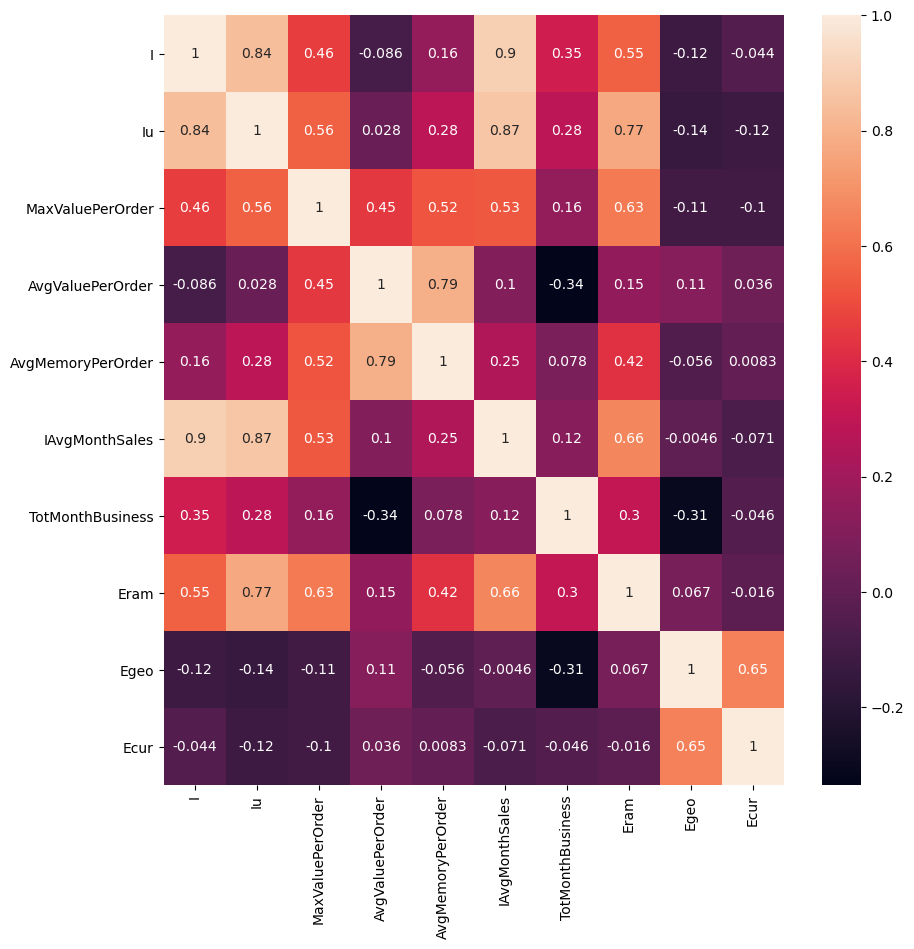

In [20]:
plt.figure(figsize=(10,10))
sn.heatmap(vendor_df_num.corr(), annot=True)
plt.show()

## Dataset preparation

### Merge all features in a single dataset

In [21]:
vendor_df = pd.concat([vendor_df_num, vendor_df_cat_discr], axis=1)
vendor_df_w_out = pd.concat([vendor_df_num_w_out, vendor_df_cat_discr_w_out], axis=1)

### Add outliers  

In [22]:
outlier_df = vendor_df_w_out.loc[~vendor_df_w_out.index.isin(vendor_df.index)]
outlier_df

I    Iu  MaxValuePerOrder  \
vendor_code name                                                
32          geizhals_unknown  2020083  1733      10630.741494   
43          Mindfactory        248228   774       6044.234544   
68          pricespy_unknown   318591  1659       4465.589602   

                              AvgValuePerOrder  AvgMemoryPerOrder  \
vendor_code name                                                    
32          geizhals_unknown        164.006403          14.541547   
43          Mindfactory             207.345263          19.361700   
68          pricespy_unknown        220.574502          20.171635   

                              IAvgMonthSales  TotMonthBusiness       Eram  \
vendor_code name                                                            
32          geizhals_unknown    5.343654e+06                62  10.512789   
43          Mindfactory         2.058756e+06                25   9.189418   
68          pricespy_unknown    1.849291e+06                38  10.118133   

                                  Egeo      Ecur  TopBrand  TopCountry  \
vendor_code name                                                         
32          geizhals_unknown  0.337642  0.000000        17           4   
43          Mindfactory       0.334336  0.000000        17           4   
68          pricespy_unknown  0.441207  0.441207         9           9   

                              TopCurrency  TopSalesMonth  
vendor_code name                                          
32          geizhals_unknown            2              3  
43          Mindfactory                 2              1  
68          pricespy_unknown            3              3

We already know from our analysis that the outliers from Task 1 present extreme values in the **I/IAvgSalesMonth** features, therefore it seems only natural to include them as **big-sellers**.

In [23]:
vend_w_out_scaler = StandardScaler()
vend_w_out_norm = vend_w_out_scaler.fit_transform(vendor_df_w_out.values)
vend_w_out_df_norm = pd.DataFrame(vend_w_out_norm, columns=vendor_df_w_out.columns, index=vendor_df_w_out.index)

vend_w_out_df_norm.head()

I        Iu  MaxValuePerOrder  \
vendor_code name                                                         
1           1stWave Technologies -0.182784 -0.625345         -0.676333   
2           Adorama              -0.171925 -0.245242          0.090633   
3           Alternate            -0.172911 -0.193958         -0.487426   
4           Alternate Italia     -0.184378 -0.501660         -0.542600   
5           Alza                 -0.129857  0.026261         -0.277209   

                                  AvgValuePerOrder  AvgMemoryPerOrder  \
vendor_code name                                                        
1           1stWave Technologies         -0.729306          -0.648874   
2           Adorama                      -0.569198          -0.308858   
3           Alternate                    -0.461887          -0.986908   
4           Alternate Italia             -0.618805          -1.314161   
5           Alza                         -0.330226          -0.552633   

                                  IAvgMonthSales  TotMonthBusiness      Eram  \
vendor_code name                                                               
1           1stWave Technologies       -0.314942          0.709453 -0.683483   
2           Adorama                    -0.285252          0.222328  0.088941   
3           Alternate                  -0.085125         -1.433894  0.432169   
4           Alternate Italia           -0.277787         -1.531318 -0.059765   
5           Alza                       -0.131547         -0.069946  0.564833   

                                      Egeo      Ecur  TopBrand  TopCountry  \
vendor_code name                                                             
1           1stWave Technologies  0.496859  0.779285 -0.925129    0.329216   
2           Adorama              -1.565545 -1.273951 -0.818855    1.107364   
3           Alternate             3.814725 -1.273951 -0.074937   -0.708314   
4           Alternate Italia      1.311293  1.590099 -0.074937    0.069834   
5           Alza                  2.168290  2.216167  1.306626    0.847981   

                                  TopCurrency  TopSalesMonth  
vendor_code name                                              
1           1stWave Technologies     0.863271       1.373472  
2           Adorama                  1.443747      -0.506016  
3           Alternate               -0.297680      -0.774514  
4           Alternate Italia        -0.297680      -0.774514  
5           Alza                     0.282796       1.641970

This time we choose to use a StandardScaler instead of a MinMaxScaler given its better handling of outliers and because the focus of this task is not the direct interpretability of these values but the behaviour of each model.

In [24]:
vend_w_out_df_norm.loc[big_seller_df_norm.index, "Label"] = "big-seller"
vend_w_out_df_norm.loc[outlier_df.index, "Label"] = "big-seller"

vend_w_out_df_norm.loc[small_seller_df_norm.index, "Label"] = "small-seller"

### Removal of features used to define labels

In [25]:
pred_df = vend_w_out_df_norm.copy().drop(["I", "IAvgMonthSales", "Iu"], axis=1)
labels = pred_df.pop('Label')

We also tried removing the **Iu** feature given its high correlation with the features removed, however the results were very lackluster across the board probably pointing out that the other features are not correlated enough with the missing ones to correctly learn the labels or that there are not enough data points to retrieve them.  
The crucial assumption being that if a model is capable of generalising sufficiently it shouldn't have a problem dealing with data points 

### Train/test split

As suggested in the literature we use a 70-30 split for training/test set.

In [26]:
#Normalised data
train_set, test_set, train_label, test_label = train_test_split(pred_df, labels, stratify=labels, test_size=0.3, random_state=0)

print(f"Train set size (unbalanced): {len(train_set)}")
print(f"Test set size (unbalanced): {len(test_set)}")

Train set size (unbalanced): 54
Test set size (unbalanced): 24


### Class balancing  
Some of the functions provided by sklearn do not allow for a weighting of the classification scores based on the support of the class, therefore we need to prepare a balanced dataset.  
In order to avoid having the model overfit by simply memorising the repeated datapoints, we will therefore generate new data using SMOTE.

In [27]:
ros = SMOTE(random_state=0)

train_set_bal, train_label_bal = ros.fit_resample(train_set, train_label)

print(f"Train set size (balanced): {len(train_set_bal)}")

Train set size (balanced): 82


Note that it balancing has to take place after the train-test split, otherwise information will bleed out into the test set, making our results less reliable.

## Auxiliary functions

### Visualisation

In [28]:
def plot_learning_curve(estimator, title, X, y, ax=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    ax : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if ax is None:
        _, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title(title)
    if ylim is not None:
        ax[0].set_ylim(*ylim)
    ax[0].set_xlabel("Training examples")
    ax[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax[0].grid()
    ax[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax[0].legend(loc="best")

    # Plot n_samples vs fit_times
    ax[1].grid()
    ax[1].plot(train_sizes, fit_times_mean, 'o-')
    ax[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    ax[1].set_xlabel("Training examples")
    ax[1].set_ylabel("fit_times")
    ax[1].set_title("Scalability of the model")

    return plt


def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                    test_pred, 
                    target_names=['big-seller', 'small-seller']))

### Plotting the decision boundaries
All the code in the following block is a modified version of the "plot_decision_regions" function from the mlxtend project.  
Our objective is to adapt the code in such a way as to plot the decision boundary of a classifier trained on multi-dimensional (>2) data without needing to retrain it on PCA-ed data or change its parameters.  

To achieve this we simply apply PCA after the datapoints have been classified inside the plot_decision_regions function

In [29]:
# Sebastian Raschka 2014-2020
# mlxtend Machine Learning Library Extensions
#
# A function for plotting decision regions of classifiers.
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.utils import check_Xy, format_kwarg_dictionaries
from math import floor
from math import ceil


def get_feature_range_mask(X, filler_feature_values=None,
                           filler_feature_ranges=None):
    """
    Function that constucts a boolean array to get rid of samples
    in X that are outside the feature range specified by filler_feature_values
    and filler_feature_ranges
    """

    if not isinstance(X, np.ndarray) or not len(X.shape) == 2:
        raise ValueError('X must be a 2D array')
    elif filler_feature_values is None:
        raise ValueError('filler_feature_values must not be None')
    elif filler_feature_ranges is None:
        raise ValueError('filler_feature_ranges must not be None')

    mask = np.ones(X.shape[0], dtype=bool)
    for feature_idx in filler_feature_ranges:
        feature_value = filler_feature_values[feature_idx]
        feature_width = filler_feature_ranges[feature_idx]
        upp_limit = feature_value + feature_width
        low_limit = feature_value - feature_width
        feature_mask = (X[:, feature_idx] > low_limit) & \
                       (X[:, feature_idx] < upp_limit)
        mask = mask & feature_mask

    return mask


def plot_decision_regions_2d_pca(X, y, clf,
                          label_map=None,
                          X_columns=None,
                          ax=None,
                          X_highlight=None,
                          zoom_factor=1.,
                          legend=1,
                          hide_spines=True,
                          markers='s^oxv<>',
                          colors=('#1f77b4,#ff7f0e,#3ca02c,#d62728,'
                                  '#9467bd,#8c564b,#e377c2,'
                                  '#7f7f7f,#bcbd22,#17becf'),
                          scatter_kwargs=None,
                          contourf_kwargs=None,
                          scatter_highlight_kwargs=None):
    """Plot decision regions of a classifier.

    Please note that this functions assumes that class labels are
    labeled consecutively, e.g,. 0, 1, 2, 3, 4, and 5. If you have class
    labels with integer labels > 4, you may want to provide additional colors
    and/or markers as `colors` and `markers` arguments.
    See http://matplotlib.org/examples/color/named_colors.html for more
    information.

    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Feature Matrix.

    y : array-like, shape = [n_samples]
        True class labels.

    clf : Classifier object.
        Must have a .predict method.
        
    label_map : dict, {classifier_label:idx}.
    
    X_columns : array-like.
        Used to reconstruct a temporary dataframe if the classifier needs it

    ax : matplotlib.axes.Axes (default: None)
        An existing matplotlib Axes. Creates
        one if ax=None.

    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
        An array with data points that are used to highlight samples in `X`.

    zoom_factor : float (default: 1.0)
        Controls the scale of the x- and y-axis of the decision plot.

    hide_spines : bool (default: True)
        Hide axis spines if True.

    legend : int (default: 1)
        Integer to specify the legend location.
        No legend if legend is 0.

    markers : str (default: 's^oxv<>')
        Scatterplot markers.

    colors : str (default: 'red,blue,limegreen,gray,cyan')
        Comma separated list of colors.

    scatter_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.

    contourf_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib contourf function.

    scatter_highlight_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.

    Returns
    ---------
    ax : matplotlib.axes.Axes object
    """

    check_Xy(X, y, y_int=True)  # Validate X and y arrays
    
    pca_dim = 2
    pca = PCA(n_components = pca_dim)
    X_pca = pca.fit_transform(X)
    dim = pca_dim

    if ax is None:
        ax = plt.gca()

    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')

    feature_index = (0, 1)
    x_index, y_index = feature_index

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = (X_pca[:, x_index].min() - 1./zoom_factor,
                    X_pca[:, x_index].max() + 1./zoom_factor)
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = (X_pca[:, y_index].min() - 1./zoom_factor,
                        X_pca[:, y_index].max() + 1./zoom_factor)

    xnum, ynum = plt.gcf().dpi * plt.gcf().get_size_inches()
    xnum, ynum = floor(xnum), ceil(ynum)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=xnum),
                         np.linspace(y_min, y_max, num=ynum))


    X_grid = np.array([xx.ravel(), yy.ravel()]).T
    X_predict = np.zeros((X_grid.shape[0], dim))
    X_predict[:, x_index] = X_grid[:, 0]
    X_predict[:, y_index] = X_grid[:, 1]
    
    X_to_predict = pca.inverse_transform(X_predict.astype(X.dtype))
    
    if X_columns is not None:
        X_to_predict = pd.DataFrame(X_to_predict, columns=X_columns)  
        
    Z = clf.predict(X_to_predict)
    
    if label_map is not None:
        Z = np.array([label_map[Z[i]] for i in range(len(Z))])
    
    Z = Z.reshape(xx.shape)
    
    # Plot decision region
    # Make sure contourf_kwargs has backwards compatible defaults
    contourf_kwargs_default = {'alpha': 0.45, 'antialiased': True}
    contourf_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contourf_kwargs_default,
                        user_kwargs=contourf_kwargs,
                        protected_keys=['colors', 'levels'])
    cset = ax.contourf(xx, yy, Z,
                       colors=colors,
                       levels=np.arange(Z.max() + 2) - 0.5,
                       **contourf_kwargs)

    ax.contour(xx, yy, Z, cset.levels,
               colors='k',
               linewidths=0.5,
               antialiased=True)

    ax.axis([xx.min(), xx.max(), yy.min(), yy.max()])

    # Scatter training data samples
    # Make sure scatter_kwargs has backwards compatible defaults
    scatter_kwargs_default = {'alpha': 0.8, 'edgecolor': 'black'}
    scatter_kwargs = format_kwarg_dictionaries(
                        default_kwargs=scatter_kwargs_default,
                        user_kwargs=scatter_kwargs,
                        protected_keys=['c', 'marker', 'label'])
    
    for idx, c in enumerate(np.unique(y)):
        y_data = X_pca[y == c, y_index]
        x_data = X_pca[y == c, x_index]

        ax.scatter(x=x_data,
                   y=y_data,
                   c=colors[idx],
                   marker=next(marker_gen),
                   label=c,
                   **scatter_kwargs)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if plot_testdata:
        x_data = X_highlight[:, x_index]
        y_data = X_highlight[:, y_index]

        # Make sure scatter_highlight_kwargs backwards compatible defaults
        scatter_highlight_defaults = {'c': 'none',
                                      'edgecolor': 'black',
                                      'alpha': 1.0,
                                      'linewidths': 1,
                                      'marker': 'o',
                                      's': 80}
        scatter_highlight_kwargs = format_kwarg_dictionaries(
                                    default_kwargs=scatter_highlight_defaults,
                                    user_kwargs=scatter_highlight_kwargs)
        ax.scatter(x_data,
                   y_data,
                   **scatter_highlight_kwargs)

    if legend:
        
        handles, labels = ax.get_legend_handles_labels()
        
        if label_map is None:
            ax.legend(handles, labels,
                      framealpha=0.3, scatterpoints=1, loc=legend)
        else:
            inv_map = {v: k for k, v in label_map.items()}
            ax.legend(handles, [inv_map[int(v)] for v in labels],
                      framealpha=0.3, scatterpoints=1, loc=legend)

    return ax

In [30]:
def plot_decision_boundary(train_sets, train_labels, clfs, titles=None, label_dict={"big-seller":1, "small-seller":0}):
    
    n_models = len(clfs)
    
    if titles != None and n_models != len(titles):
        raise RuntimeError
    
    gs = gridspec.GridSpec((n_models+1)//2, 2)
    fig = plt.figure(figsize=(15,5*(n_models+1)//2))

    for clf, t_set, t_lab, title, grd in zip(clfs,
                         train_sets,
                         train_labels,
                         titles,
                         itertools.product([0, 1], repeat=2)):
        
        X = t_set.values
        y = np.array(t_lab.replace(label_dict))
        
        ax = plt.subplot(gs[grd[0], grd[1]])
        
        fig = plot_decision_regions_2d_pca(X=X, y=y, clf=clf, legend=2, label_map=label_dict, X_columns=t_set.columns)
        
        plt.title(title)
    
    plt.show()

When using this function keep in mind that this is useful just to get a feel for what the model is doing.  
We can see that a pca transformation of these datasets, using only 2 components, is able to explain only about half of the variance.

In [31]:
np.sum(PCA(n_components = 2).fit(train_set).explained_variance_ratio_)

0.5590030997565771

In [32]:
np.sum(PCA(n_components = 2).fit(train_set_bal).explained_variance_ratio_)

0.5710686226320068

## Decision trees

### Parameter search and fitting

We chose to set the min_samples_leaf value to 1, following a rule of thumb for small datasets and limit the number of features to the interval [2,3,4], since for each increase in the number of features considered a decision tree needs a significant amount of additional data to avoid overfitting.  
The lower limit of the interval is due to the correlations of the features, we know that no single feature has a strong enough correlation to explain the hidden behaviour.  

In [33]:
random_state_dt = 0

In order to make a more apple-to-apple comparison we will pick a random_state and use it across decision trees.  

The variance in the prediction results that can be seen by removing this variable is due to the tendency of decision trees to alter dramatically their structure for each perturbation of the training set.  
This is one of the reasons for the success of random forests compared to single decision trees.  

#### Unbalanced classes

In [34]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 5),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": range(2, 5),
              "criterion": ["gini", "entropy"],
              "random_state": [random_state_dt]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_unb = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_dt_unb.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_unb.cv_results_['mean_test_score'][0], 
      grid_search_dt_unb.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_unb = tree.DecisionTreeClassifier(**grid_search_dt_unb.best_params_)
dt_unb.fit(train_set, train_label)

test_pred_dt_unb = dt_unb.predict(test_set)
test_pred_proba_dt_unb = dt_unb.predict_proba(test_set)

Best settings parameters  {'criterion': 'gini', 'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 9, 'random_state': 0}
Setting's accuracy score mean and std  0.8163636363636364 0.09797958971132713


#### Balanced classes

In [35]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 5),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": range(2, 5),
              "criterion": ["gini", "entropy"],
              "random_state": [random_state_dt]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_bal = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_dt_bal.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_bal.cv_results_['mean_test_score'][0], 
      grid_search_dt_bal.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_bal = tree.DecisionTreeClassifier(**grid_search_dt_bal.best_params_)
dt_bal.fit(train_set_bal, train_label_bal)

test_pred_dt_bal = dt_bal.predict(test_set)
test_pred_proba_dt_bal = dt_bal.predict_proba(test_set)

Best settings parameters  {'criterion': 'gini', 'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}
Setting's accuracy score mean and std  0.8801470588235294 0.0827197712377955


#### Balanced classes with class_weight

In [36]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 5),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": range(2, 5),
              "criterion": ["gini", "entropy"],
              "class_weight": ["balanced"],
              "random_state": [random_state_dt]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_wei = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_dt_wei.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_wei.cv_results_['mean_test_score'][0], 
      grid_search_dt_wei.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_wei = tree.DecisionTreeClassifier(**grid_search_dt_wei.best_params_)
dt_wei.fit(train_set, train_label)

test_pred_dt_wei = dt_wei.predict(test_set)
test_pred_proba_dt_wei = dt_wei.predict_proba(test_set)

Best settings parameters  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 0}
Setting's accuracy score mean and std  0.8181818181818181 0.15212000482437738


### Evaluation

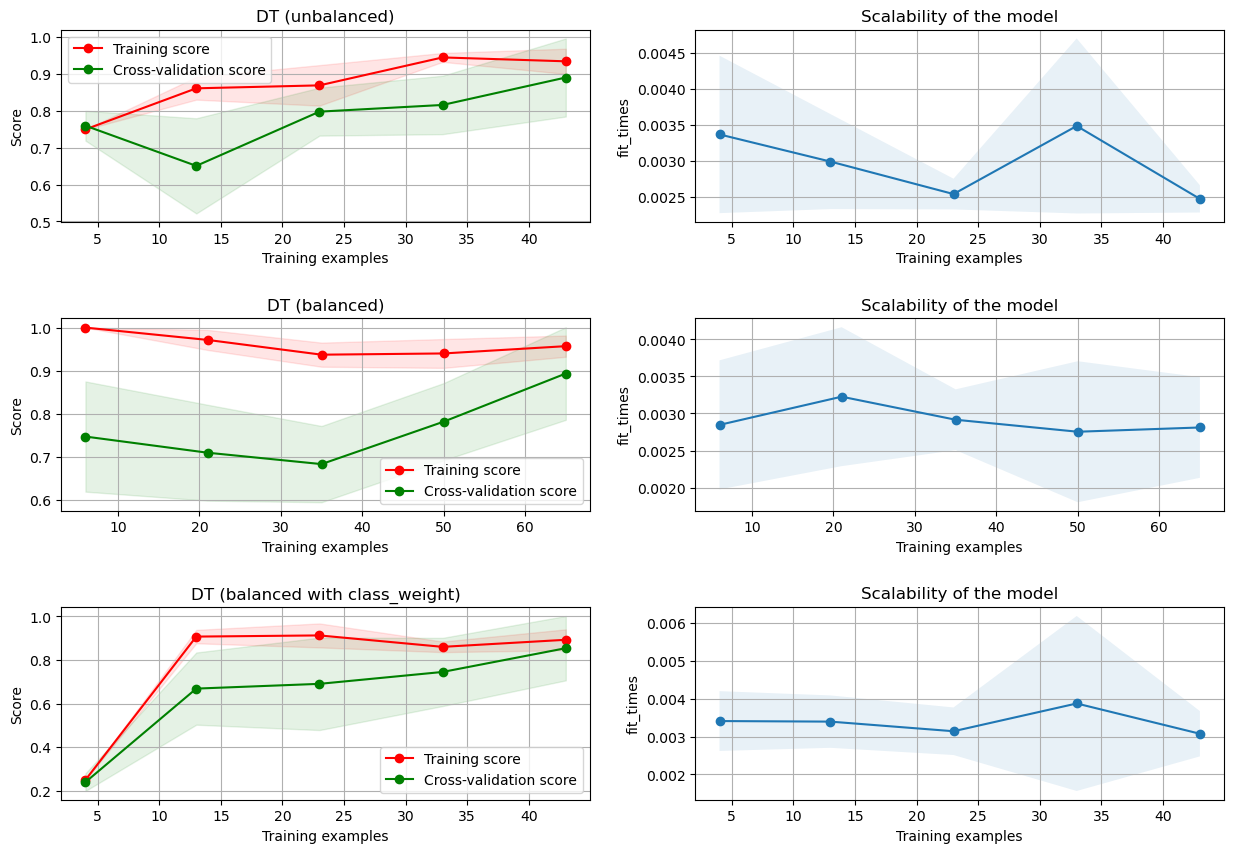

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plot_learning_curve(dt_unb, "DT (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(dt_bal, "DT (balanced)", train_set_bal, train_label_bal, ax=axes[1])
plot_learning_curve(dt_wei, "DT (balanced with class_weight)", train_set,train_label, ax=axes[2])

plt.show()

The learning curve suggests, through the upward trend of the cv score, that the model would benefit from more data points, as we pointed out above.

DT (unbalanced)


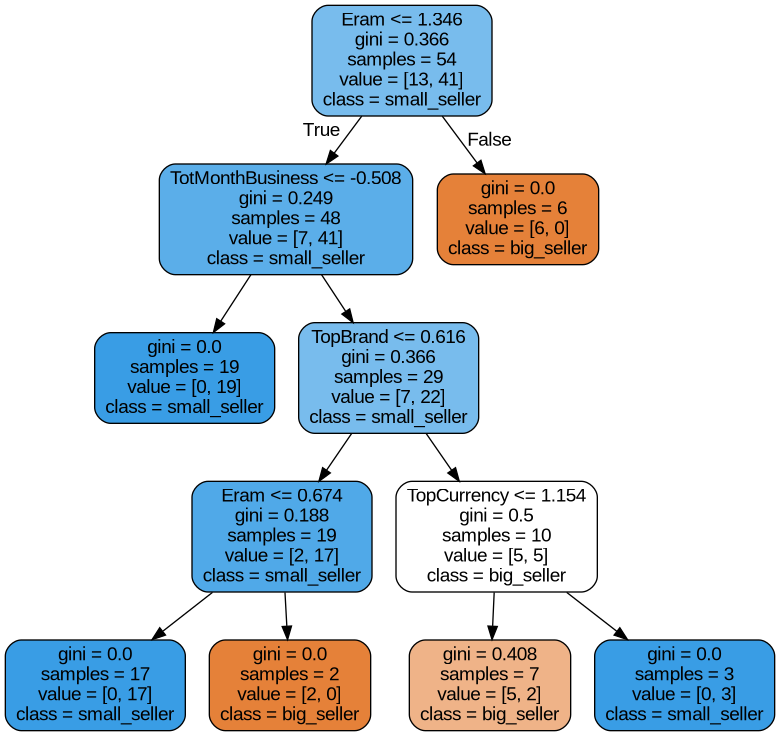

In [38]:
print("DT (unbalanced)")
dot_data = tree.export_graphviz(dt_unb, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

DT (balanced)


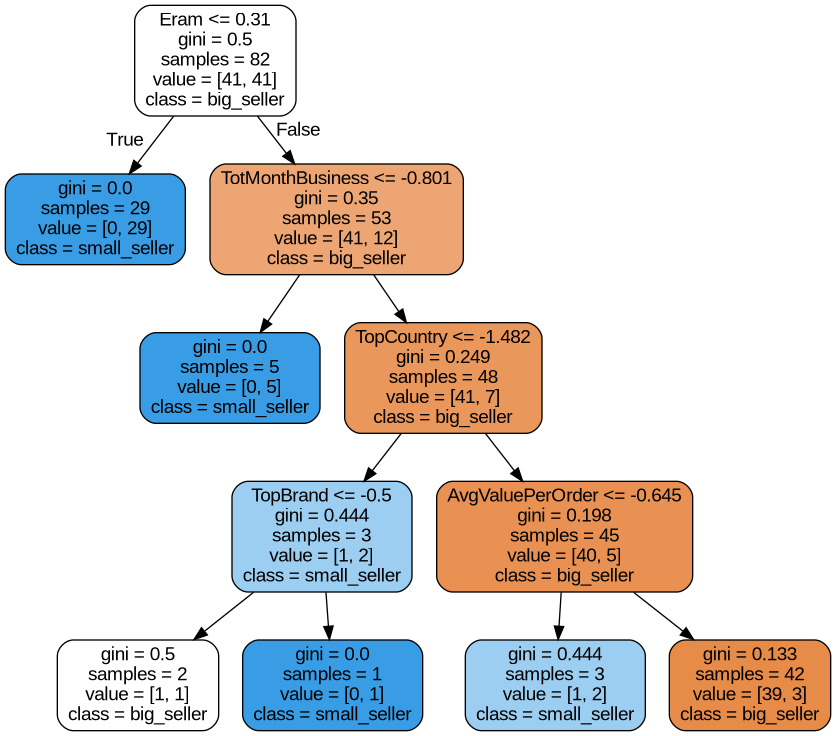

In [39]:
print("DT (balanced)")
dot_data = tree.export_graphviz(dt_bal, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

DT (balanced with class_weight)


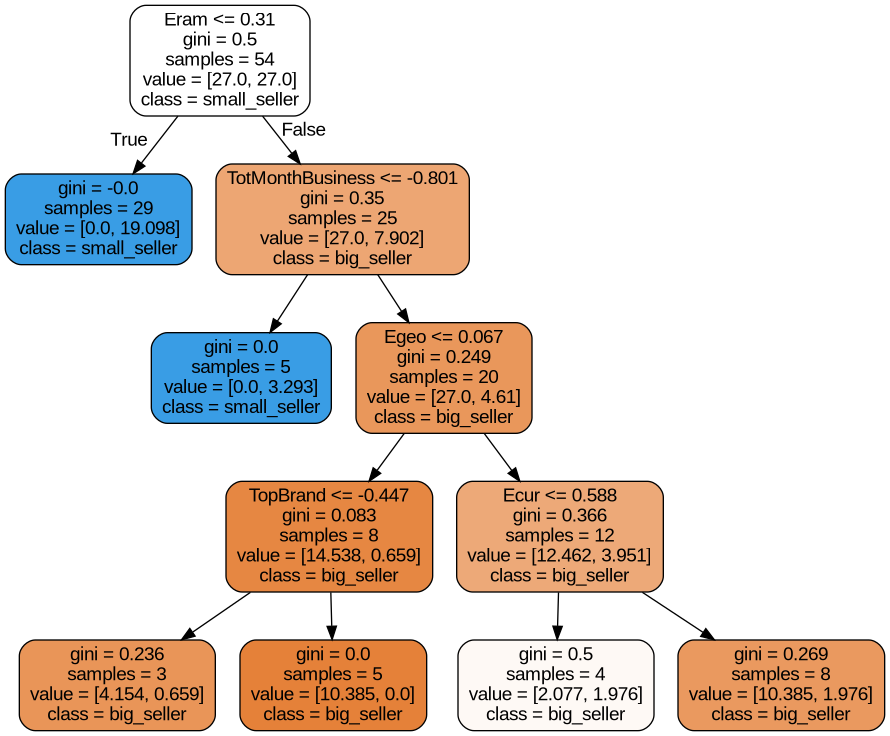

In [40]:
print("DT (balanced with class_weight)")
dot_data = tree.export_graphviz(dt_wei, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [41]:
print("DT (unbalanced)")
report_scores(test_label, test_pred_dt_unb)
print("\n")
print("DT (balanced)")
report_scores(test_label, test_pred_dt_bal)
print("\n")
print("DT (balanced with class_weight)")
report_scores(test_label, test_pred_dt_wei)

DT (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.86      1.00      0.92         6
small-seller       1.00      0.94      0.97        18

    accuracy                           0.96        24
   macro avg       0.93      0.97      0.95        24
weighted avg       0.96      0.96      0.96        24



DT (balanced)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



DT (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.50      0.83      0.62         6
small-seller       0.93      0.72      0.81        18

    accuracy                           0.75        24
   macro avg       0.71      0.78      0.72        24
weighted

Both the metrics results and size of the decision tree seem to point to a case of overfitting in the first two decision trees, let's try to limit their complexity through filtering the nodes using ccp_alpha coefficients.

### Post-pruning  
Of the first two decision trees.

In [42]:
def ccp_alpha_pruning(dt, dt_params, dataset, labels, title=None):
    
    if title:
        print(title)
        
    path = dt.cost_complexity_pruning_path(dataset, labels)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    fig, ax = plt.subplots(3, 1, figsize=(10,10))

    ax[0].plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
    ax[0].set_xlabel("Effective alpha")
    ax[0].set_ylabel("Total impurity of leaves")
    ax[0].set_title("Total Impurity vs effective alpha for training set")

    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(**dt_params, ccp_alpha=ccp_alpha)
        clf.fit(dataset, labels)
        clfs.append(clf)

    print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
          clfs[-1].tree_.node_count, ccp_alphas[-1]))


    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    ax[1].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("number of nodes")
    ax[1].set_title("Number of nodes vs alpha")
    ax[2].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
    ax[2].set_xlabel("alpha")
    ax[2].set_ylabel("depth of tree")
    ax[2].set_title("Depth vs alpha")
    fig.tight_layout()
    
    return ccp_alphas

DT (unbalanced)
Number of nodes in the last tree is: 1 with ccp_alpha: 0.1441186556927298


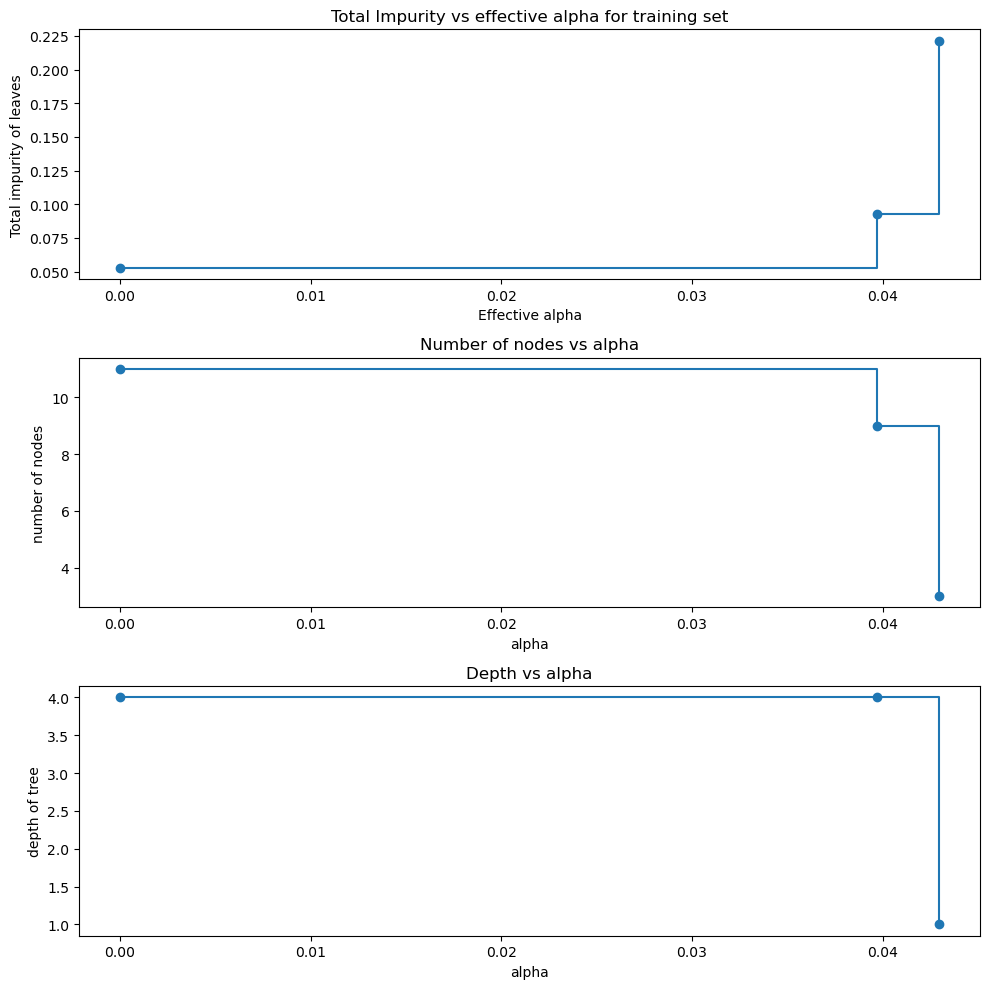

In [43]:
ccp_alphas_unb = ccp_alpha_pruning(dt_unb, grid_search_dt_unb.best_params_, train_set, train_label, "DT (unbalanced)")

DT (balanced)
Number of nodes in the last tree is: 1 with ccp_alpha: 0.2735849056603774


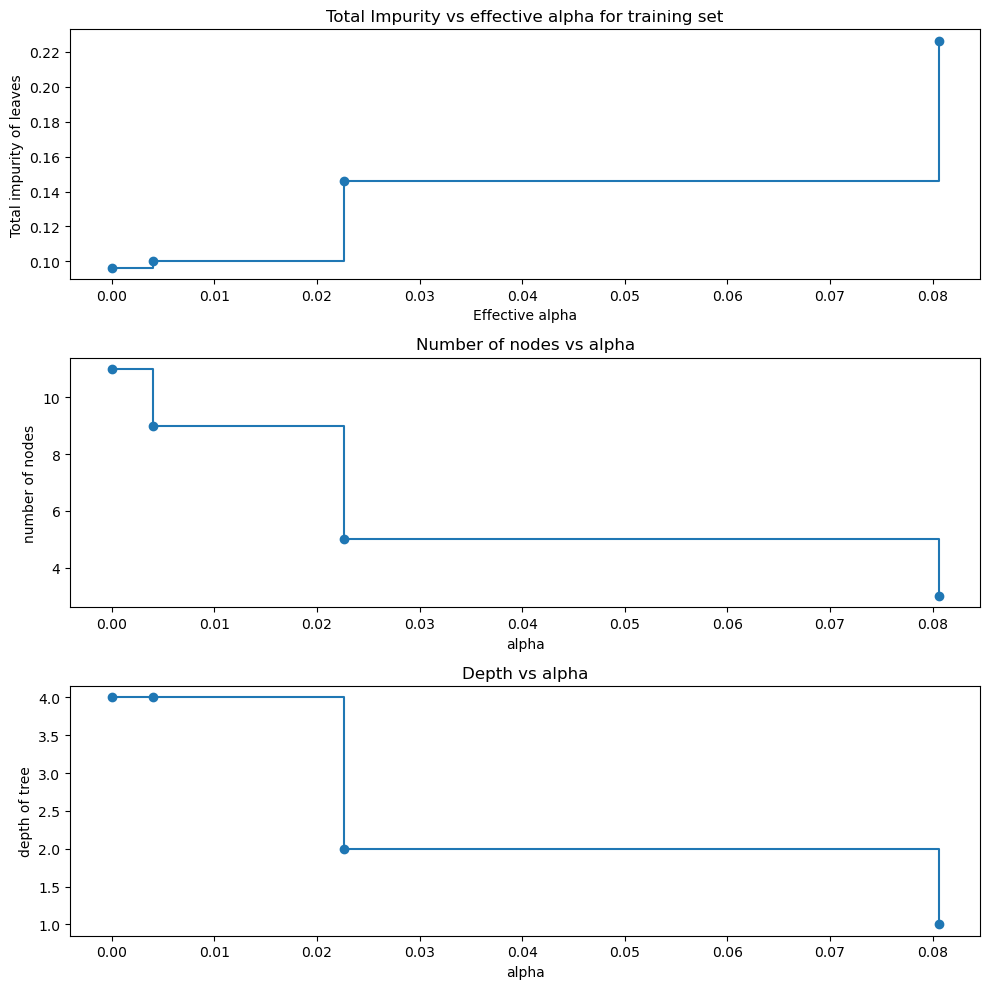

In [44]:
ccp_alphas_bal = ccp_alpha_pruning(dt_bal, grid_search_dt_bal.best_params_, train_set_bal, train_label_bal, "DT (balanced)")

DT (balanced ith class_weight)
Number of nodes in the last tree is: 1 with ccp_alpha: 0.2735849056603772


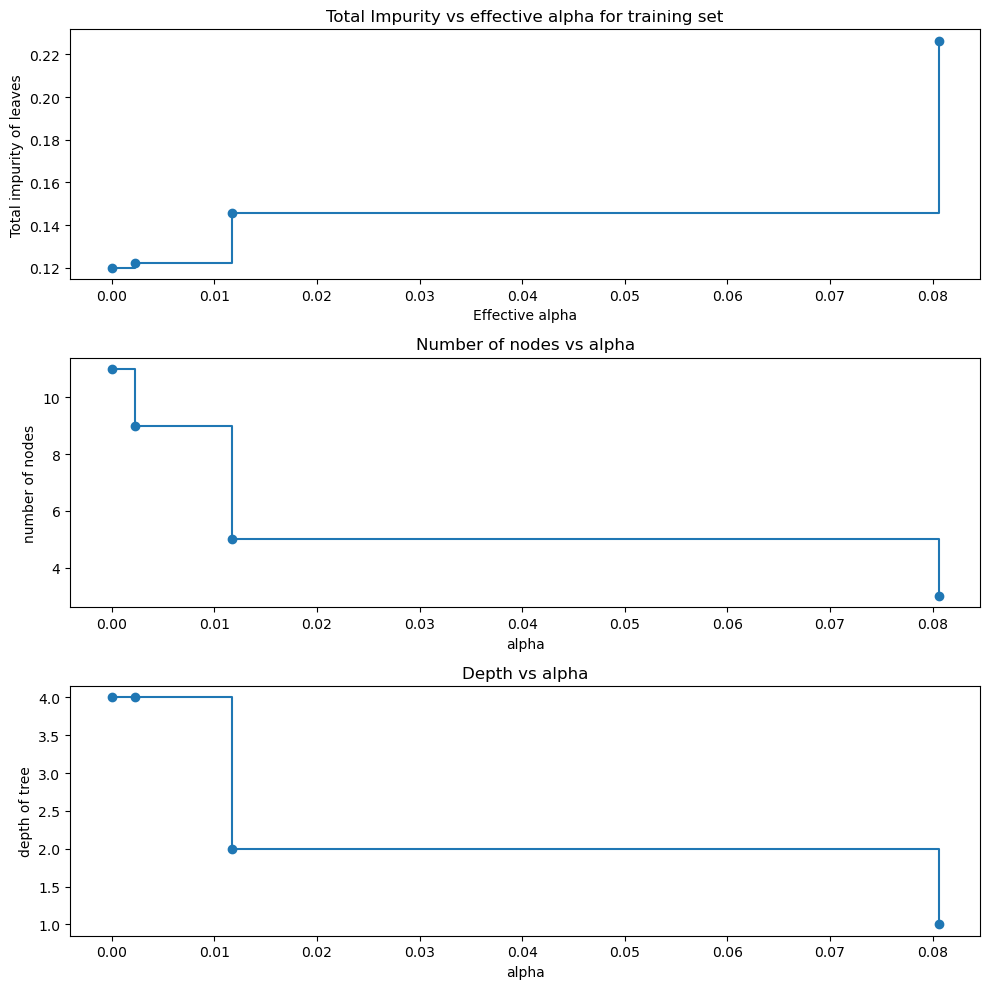

In [45]:
ccp_alphas_wei = ccp_alpha_pruning(dt_wei, grid_search_dt_wei.best_params_, train_set, train_label, "DT (balanced ith class_weight)")

We will ignore the cutoff points that reduce the trees to a single level/feature since they wouldn't have the capability to learn enough.

In [46]:
dt_unb_post = tree.DecisionTreeClassifier(**grid_search_dt_unb.best_params_, ccp_alpha=ccp_alphas_unb[-2])
dt_unb_post.fit(train_set, train_label)

test_pred_dt_unb_post = dt_unb_post.predict(test_set)
test_pred_proba_dt_unb_post = dt_unb_post.predict_proba(test_set)


dt_bal_post = tree.DecisionTreeClassifier(**grid_search_dt_bal.best_params_, ccp_alpha=ccp_alphas_bal[-2])
dt_bal_post.fit(train_set_bal, train_label_bal)

test_pred_dt_bal_post = dt_bal_post.predict(test_set)
test_pred_proba_dt_bal_post = dt_bal_post.predict_proba(test_set)


dt_wei_post = tree.DecisionTreeClassifier(**grid_search_dt_wei.best_params_, ccp_alpha=ccp_alphas_wei[-2])
dt_wei_post.fit(train_set, train_label)

test_pred_dt_wei_post = dt_wei_post.predict(test_set)
test_pred_proba_dt_wei_post = dt_wei_post.predict_proba(test_set)

DT (unbalanced, post-pruned)


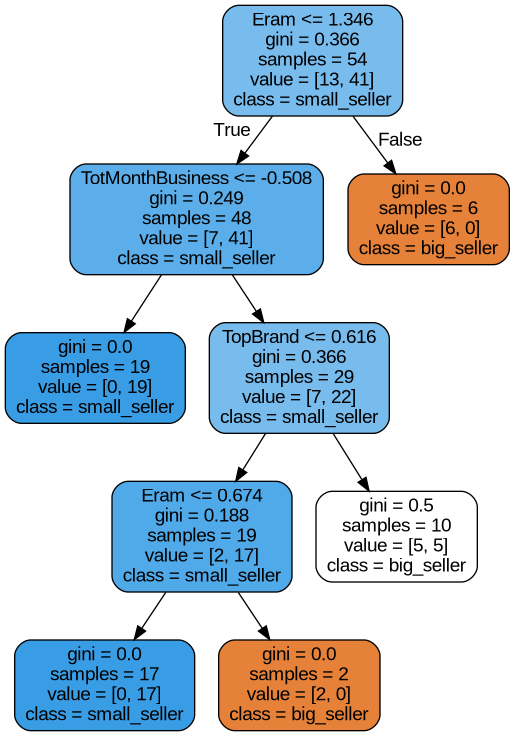

In [47]:
print("DT (unbalanced, post-pruned)")
dot_data = tree.export_graphviz(dt_unb_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

The tree cannot be further reduced.

DT (balanced, post-pruned)


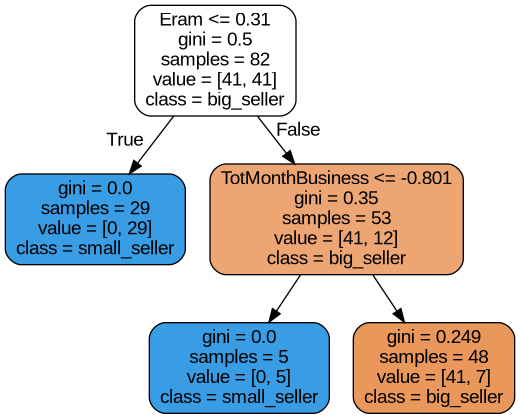

In [48]:
print("DT (balanced, post-pruned)")
dot_data = tree.export_graphviz(dt_bal_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

DT (balanced with class_weight, post-pruned)


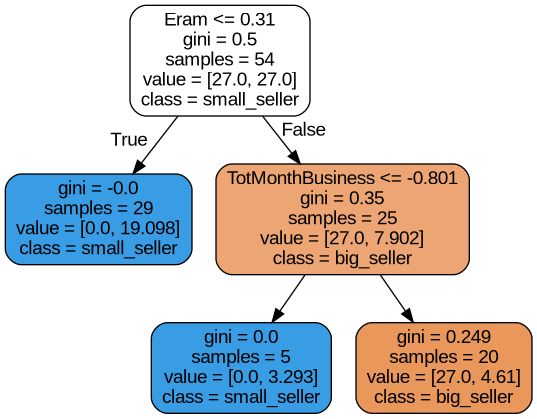

In [49]:
print("DT (balanced with class_weight, post-pruned)")
dot_data = tree.export_graphviz(dt_wei_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [50]:
print("DT (unbalanced)")
report_scores(test_label, test_pred_dt_unb_post)
print("\n")
print("DT (balanced)")
report_scores(test_label, test_pred_dt_bal_post)
print("\n")
print("DT (balanced with class_weight)")
report_scores(test_label, test_pred_dt_wei_post)

DT (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.75      1.00      0.86         6
small-seller       1.00      0.89      0.94        18

    accuracy                           0.92        24
   macro avg       0.88      0.94      0.90        24
weighted avg       0.94      0.92      0.92        24



DT (balanced)
              precision    recall  f1-score   support

  big-seller       0.50      0.83      0.62         6
small-seller       0.93      0.72      0.81        18

    accuracy                           0.75        24
   macro avg       0.71      0.78      0.72        24
weighted avg       0.82      0.75      0.77        24



DT (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.50      0.83      0.62         6
small-seller       0.93      0.72      0.81        18

    accuracy                           0.75        24
   macro avg       0.71      0.78      0.72        24
weighted

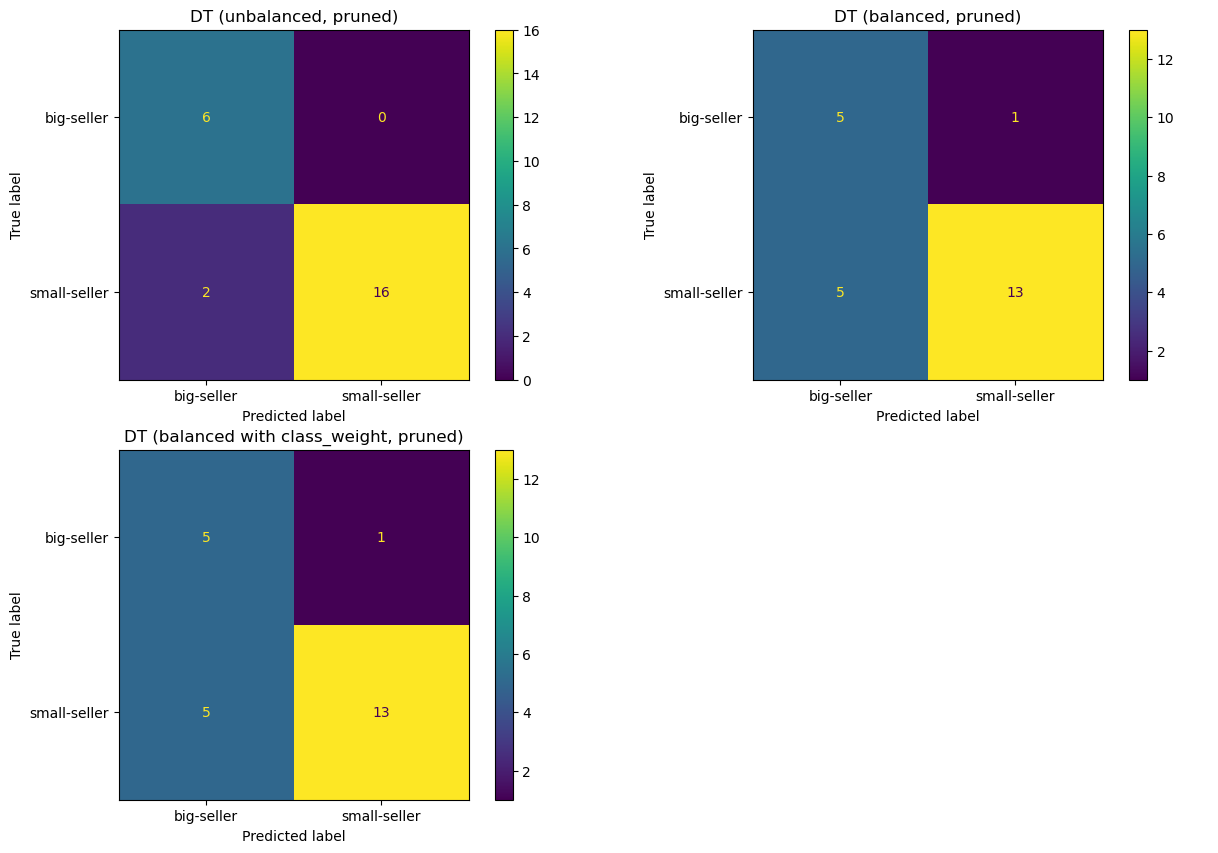

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0][0].set_title("DT (unbalanced, pruned)")
plot_confusion_matrix(dt_unb_post, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("DT (balanced, pruned)")
plot_confusion_matrix(dt_bal_post, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("DT (balanced with class_weight, pruned)")
plot_confusion_matrix(dt_wei_post, test_set, test_label, ax=axes[1][0])
axes[1][1].axis('off')
plt.show() 

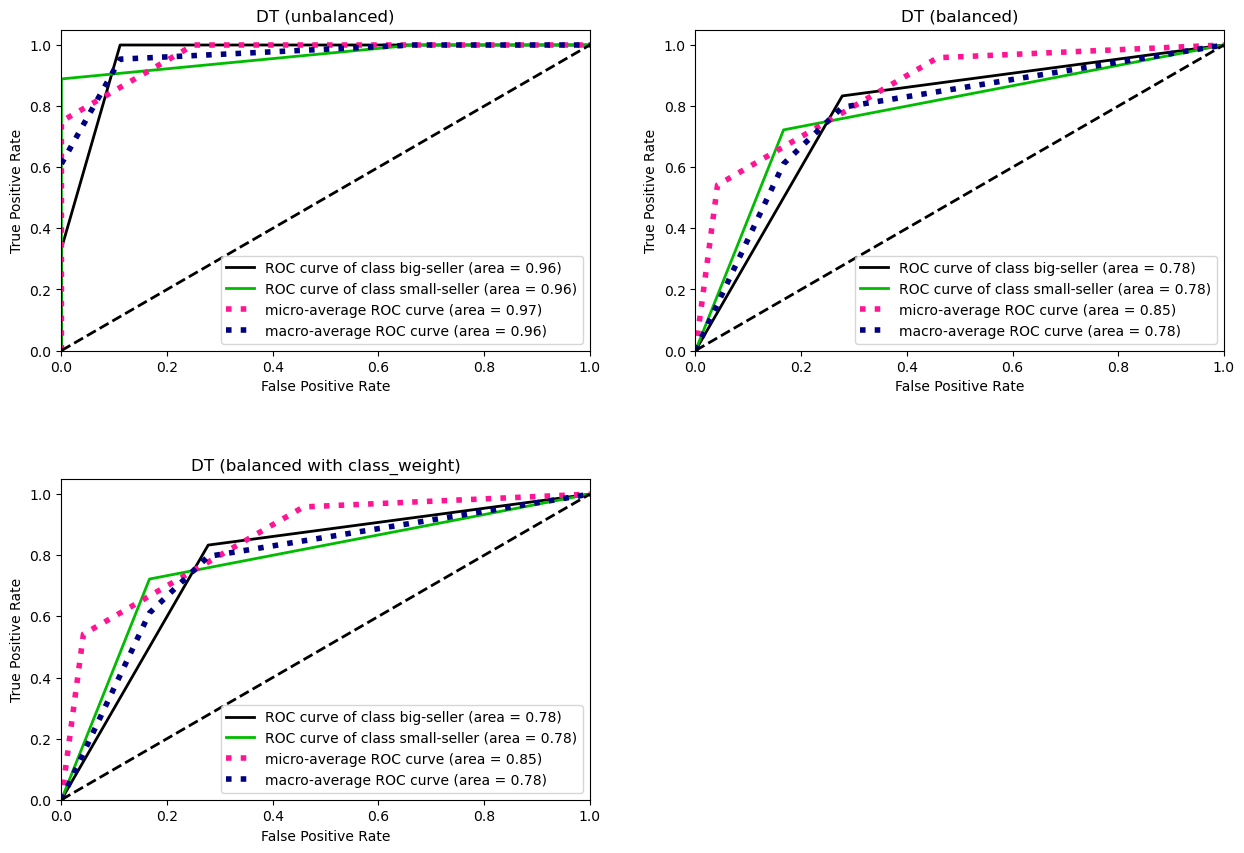

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_unb_post, title="DT (unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_bal_post, title="DT (balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_wei_post, title="DT (balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

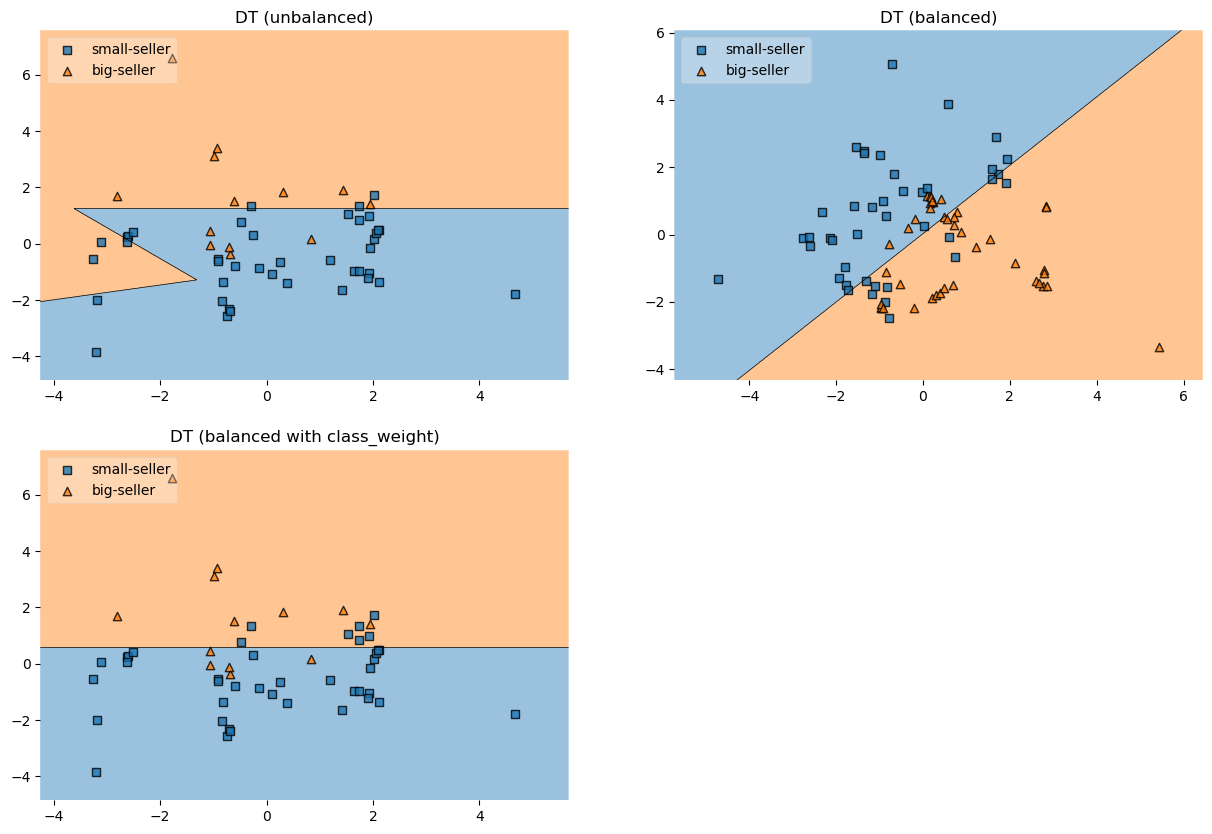

In [53]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [dt_unb_post, dt_bal_post, dt_wei_post], ["DT (unbalanced)", "DT (balanced)", "DT (balanced with class_weight)"])

Note that the balanced dataset changes the pca components.

### Conclusions
The metrics point to the model trained to the tree trained on the unbalanced dataset as the best one.  
This is due to its greater depth and number of features used to distinguish the datapoints.  
The results obtained from the balanced dataset and the tree with a "balanced" class_weight parameter are identical.

## Naives Bayes classifier (GaussianNB)

### Fitting

#### Unbalanced classes

In [54]:
gnb_unb = GaussianNB()
gnb_unb.fit(train_set, train_label)

test_pred_gnb_unb = gnb_unb.predict(test_set)
test_pred_proba_gnb_unb = gnb_unb.predict_proba(test_set)

#### Balanced classes

In [55]:
gnb_bal = GaussianNB()
gnb_bal.fit(train_set_bal, train_label_bal)

test_pred_gnb_bal = gnb_bal.predict(test_set)
test_pred_proba_gnb_bal = gnb_bal.predict_proba(test_set)

### Evaluation

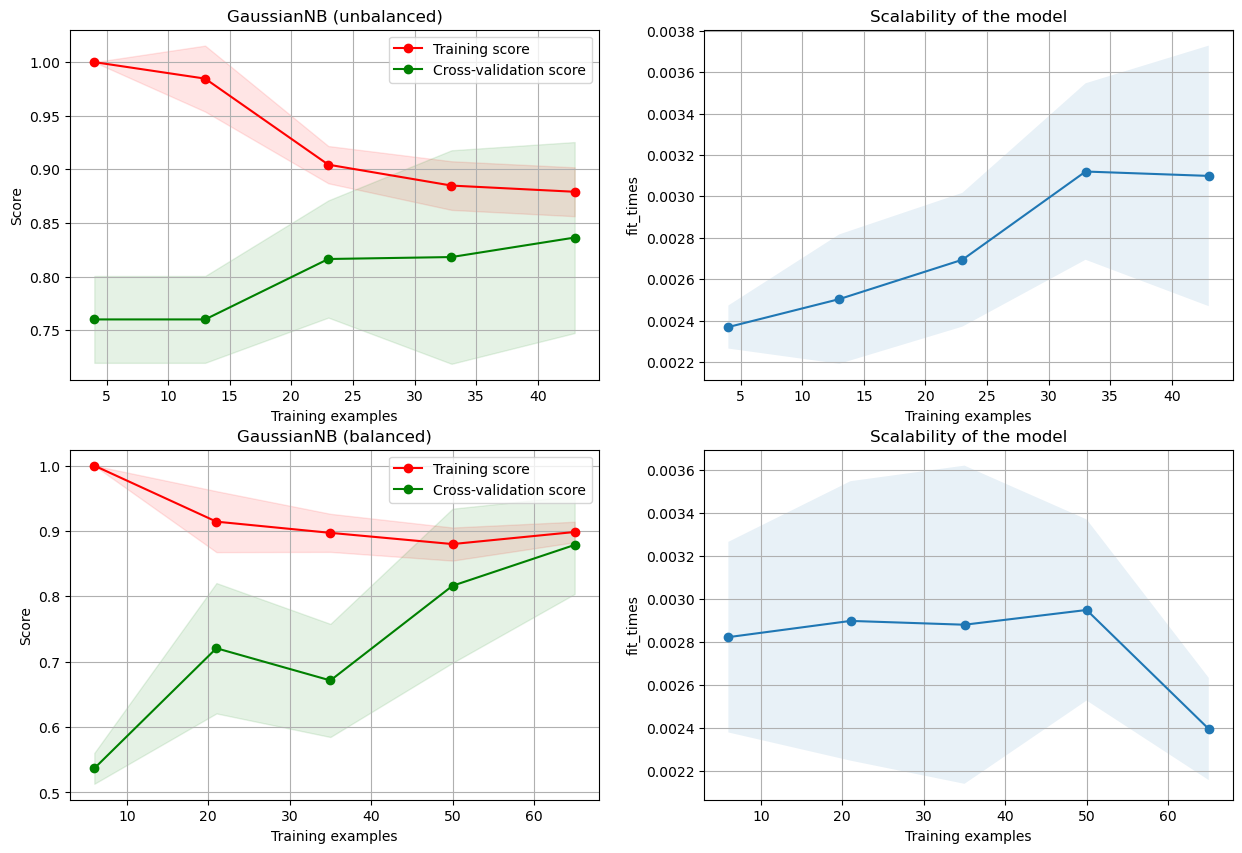

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_learning_curve(gnb_unb, "GaussianNB (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(gnb_bal, "GaussianNB (balanced)", train_set_bal, train_label_bal, ax=axes[1])

plt.show()

In [57]:
print("GaussianNB (unbalanced)")
report_scores(test_label, test_pred_gnb_unb)
print("\n")
print("GaussianNB (balanced)")
report_scores(test_label, test_pred_gnb_bal)

GaussianNB (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



GaussianNB (balanced)
              precision    recall  f1-score   support

  big-seller       0.67      1.00      0.80         6
small-seller       1.00      0.83      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.92      0.85        24
weighted avg       0.92      0.88      0.88        24



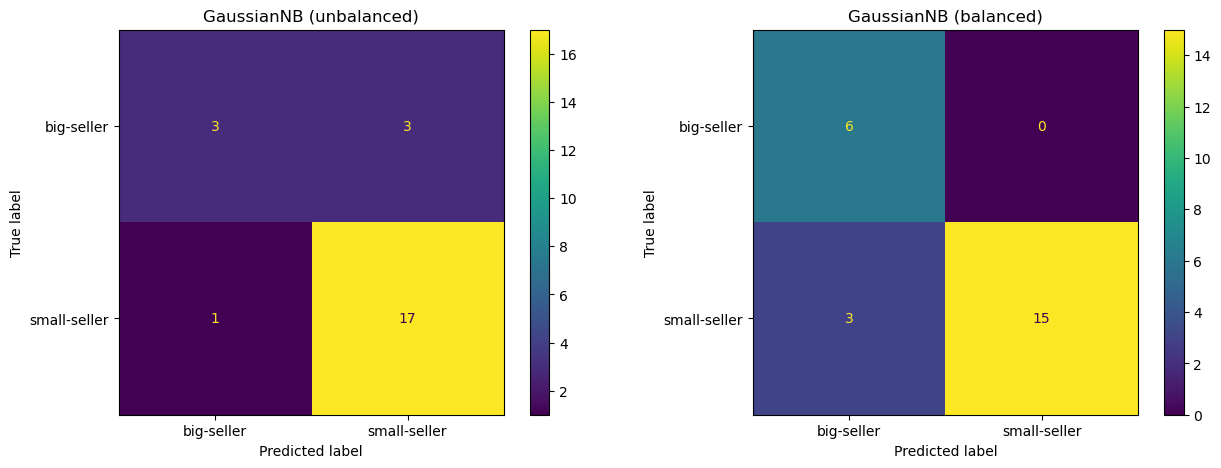

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("GaussianNB (unbalanced)")
plot_confusion_matrix(gnb_unb, test_set, test_label, ax=axes[0])
axes[1].set_title("GaussianNB (balanced)")
plot_confusion_matrix(gnb_bal, test_set, test_label, ax=axes[1])
plt.show() 

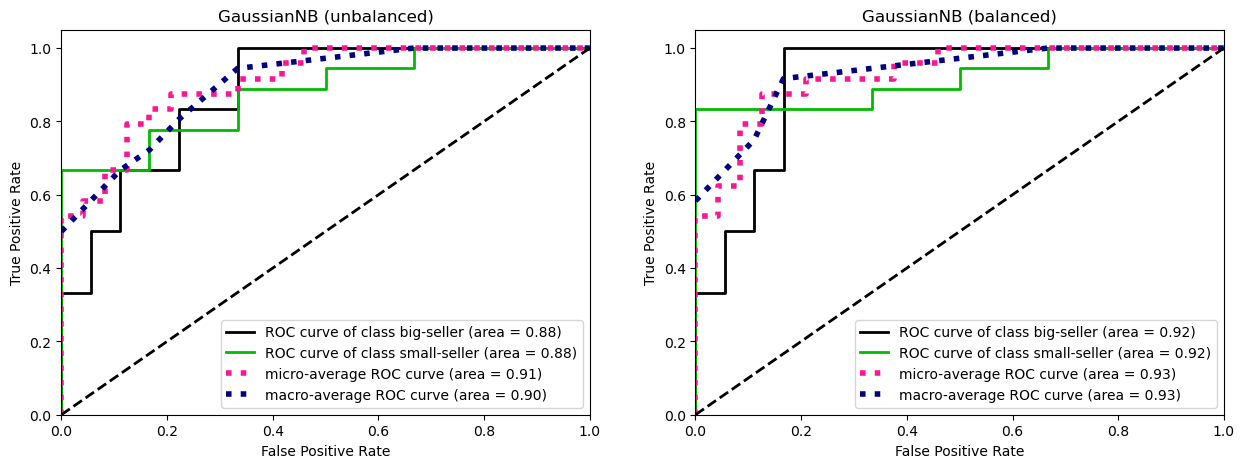

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_gnb_unb, title="GaussianNB (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_gnb_bal, title="GaussianNB (balanced)", ax=axes[1])
plt.show()

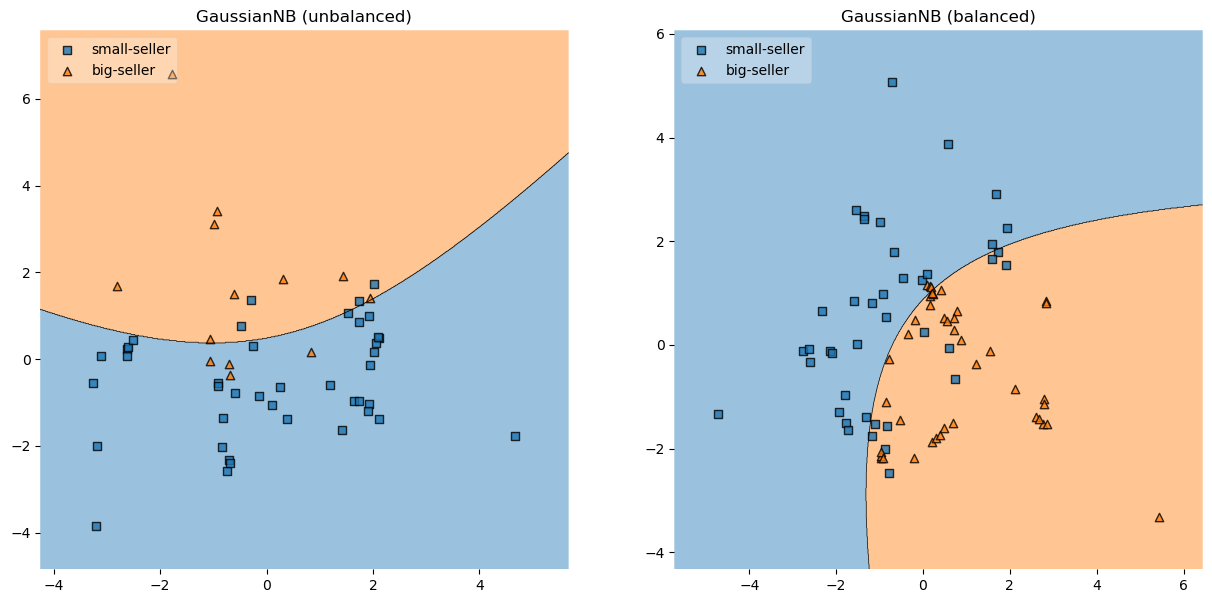

In [60]:
plot_decision_boundary([train_set, train_set_bal], [train_label, train_label_bal], \
                       [gnb_unb, gnb_bal], ["GaussianNB (unbalanced)", "GaussianNB (balanced)"])

### Conclusions
The balanced dataset performed better overall, it showed a slightly lower precision for the big-seller label compared to the unbalanced one.  
However it has a recall of 1, meaning that all of the big sellers are detected as such.

## Random forest

In [61]:
random_state_rf = 0

### Unbalanced

In [62]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 5), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_unb = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_unb.cv_results_['mean_test_score'][0], 
      grid_search_rf_unb.cv_results_['std_test_score'][0])


rf_unb = RandomForestClassifier(**grid_search_rf_unb.best_params_) 
rf_unb = rf_unb.fit(train_set, train_label)

test_pred_rf_unb = rf_unb.predict(test_set)
test_pred_proba_rf_unb = rf_unb.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 35, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 1, 'criterion': 'gini', 'bootstrap': True}
Setting's accuracy score mean and std  0.8527272727272728 0.04240692287160216


### Balanced

In [63]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 5), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_bal = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_bal.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_bal.cv_results_['mean_test_score'][0], 
      grid_search_rf_bal.cv_results_['std_test_score'][0])


rf_bal = RandomForestClassifier(**grid_search_rf_bal.best_params_) 
rf_bal = rf_bal.fit(train_set_bal, train_label_bal)

test_pred_rf_bal = rf_bal.predict(test_set)
test_pred_proba_rf_bal = rf_bal.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 6, 'max_depth': 2, 'criterion': 'entropy', 'bootstrap': True}
Setting's accuracy score mean and std  0.8545454545454547 0.09270944570168697


### Balanced with class_weight

In [64]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 5), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True], 
              "class_weight": ["balanced"],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_wei = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_wei.cv_results_['mean_test_score'][0], 
      grid_search_rf_wei.cv_results_['std_test_score'][0])


rf_wei = RandomForestClassifier(**grid_search_rf_wei.best_params_) 
rf_wei = rf_wei.fit(train_set, train_label)

test_pred_rf_wei = rf_wei.predict(test_set)
test_pred_proba_rf_wei = rf_wei.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 4, 'max_depth': 2, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}
Setting's accuracy score mean and std  0.7054545454545454 0.130808041808036


### Evaluation

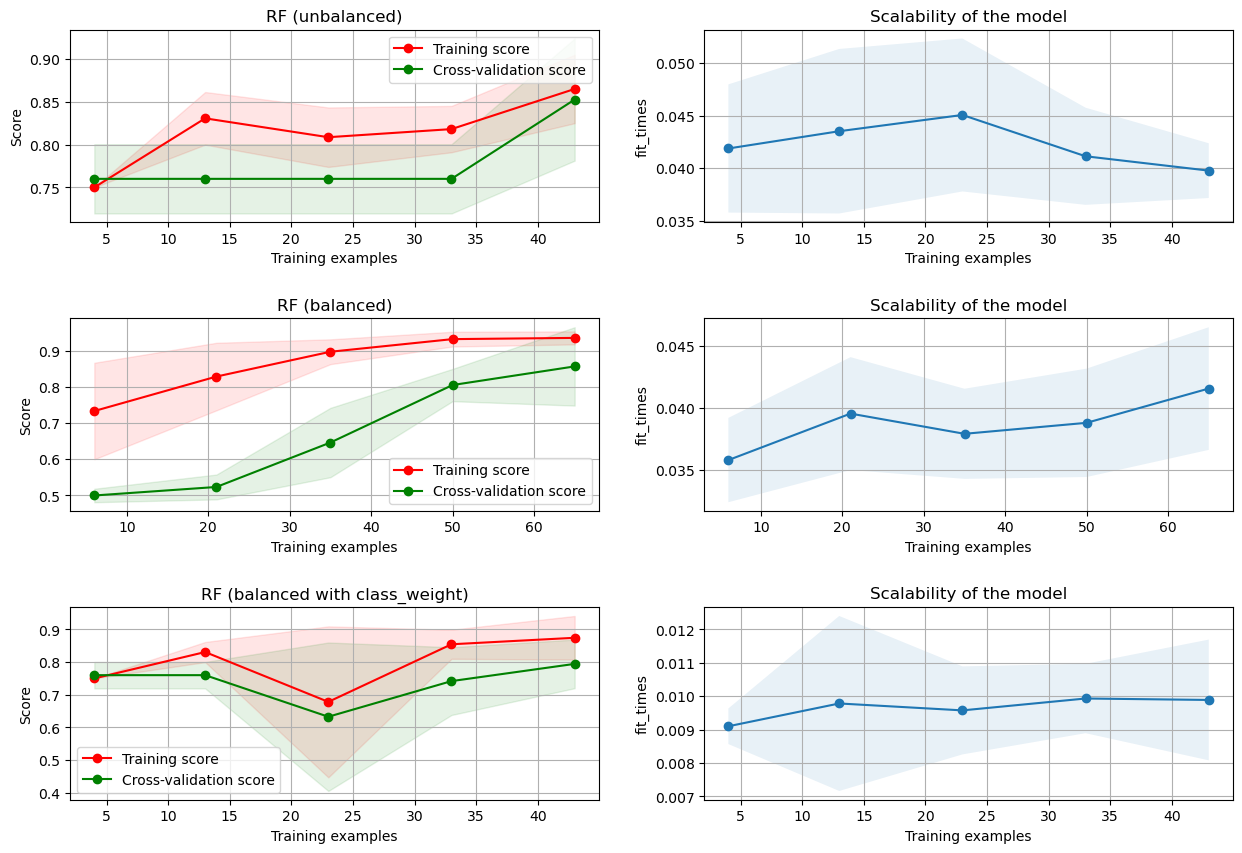

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plot_learning_curve(rf_unb, "RF (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(rf_bal, "RF (balanced)", train_set_bal, train_label_bal, ax=axes[1])
plot_learning_curve(rf_wei, "RF (balanced with class_weight)", train_set, train_label, ax=axes[2])

plt.show()

In [66]:
print("RF (unbalanced)")
report_scores(test_label, test_pred_rf_unb)
print("\n")
print("RF (balanced)")
report_scores(test_label, test_pred_rf_bal)
print("\n")
print("RF (balanced with class_weight)")
report_scores(test_label, test_pred_rf_wei)

RF (unbalanced)
              precision    recall  f1-score   support

  big-seller       1.00      0.33      0.50         6
small-seller       0.82      1.00      0.90        18

    accuracy                           0.83        24
   macro avg       0.91      0.67      0.70        24
weighted avg       0.86      0.83      0.80        24



RF (balanced)
              precision    recall  f1-score   support

  big-seller       0.56      0.83      0.67         6
small-seller       0.93      0.78      0.85        18

    accuracy                           0.79        24
   macro avg       0.74      0.81      0.76        24
weighted avg       0.84      0.79      0.80        24



RF (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.43      1.00      0.60         6
small-seller       1.00      0.56      0.71        18

    accuracy                           0.67        24
   macro avg       0.71      0.78      0.66        24
weighted

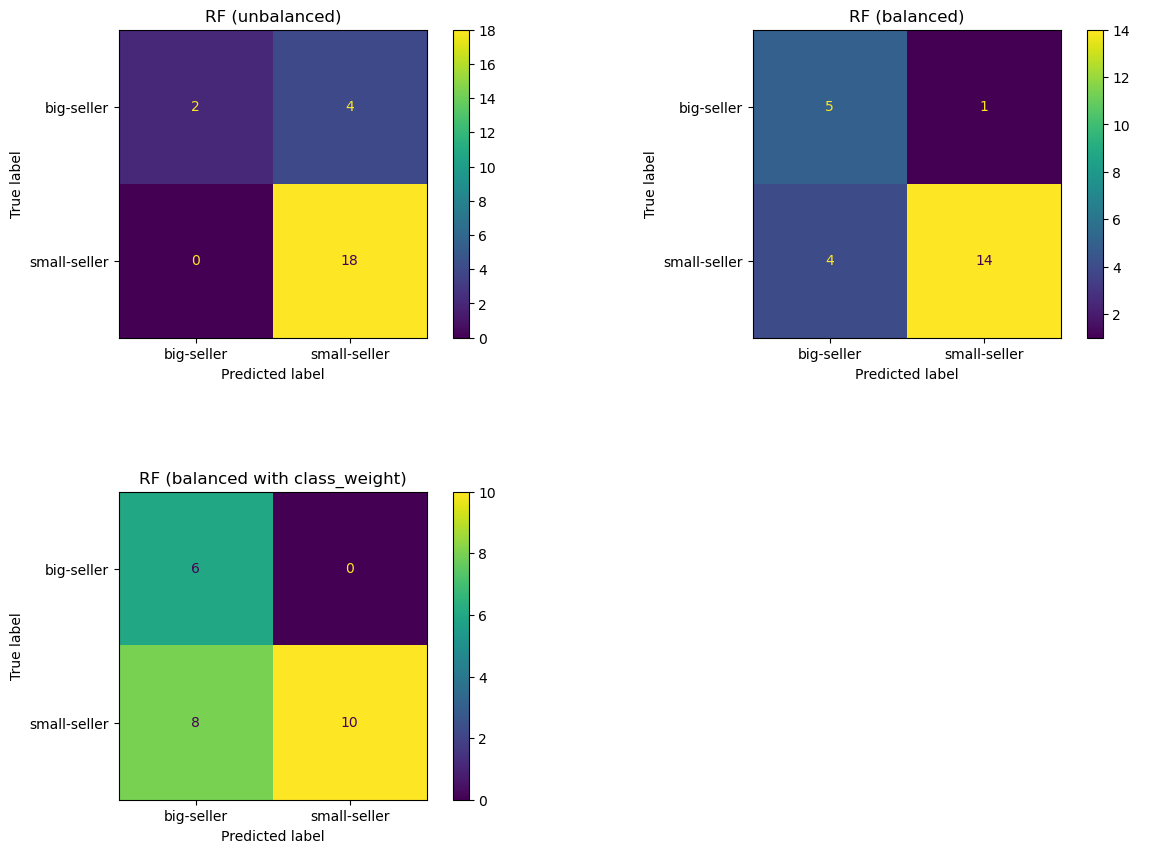

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("RF (unbalanced)")
plot_confusion_matrix(rf_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("RF (balanced)")
plot_confusion_matrix(rf_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("RF (balanced with class_weight)")
plot_confusion_matrix(rf_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

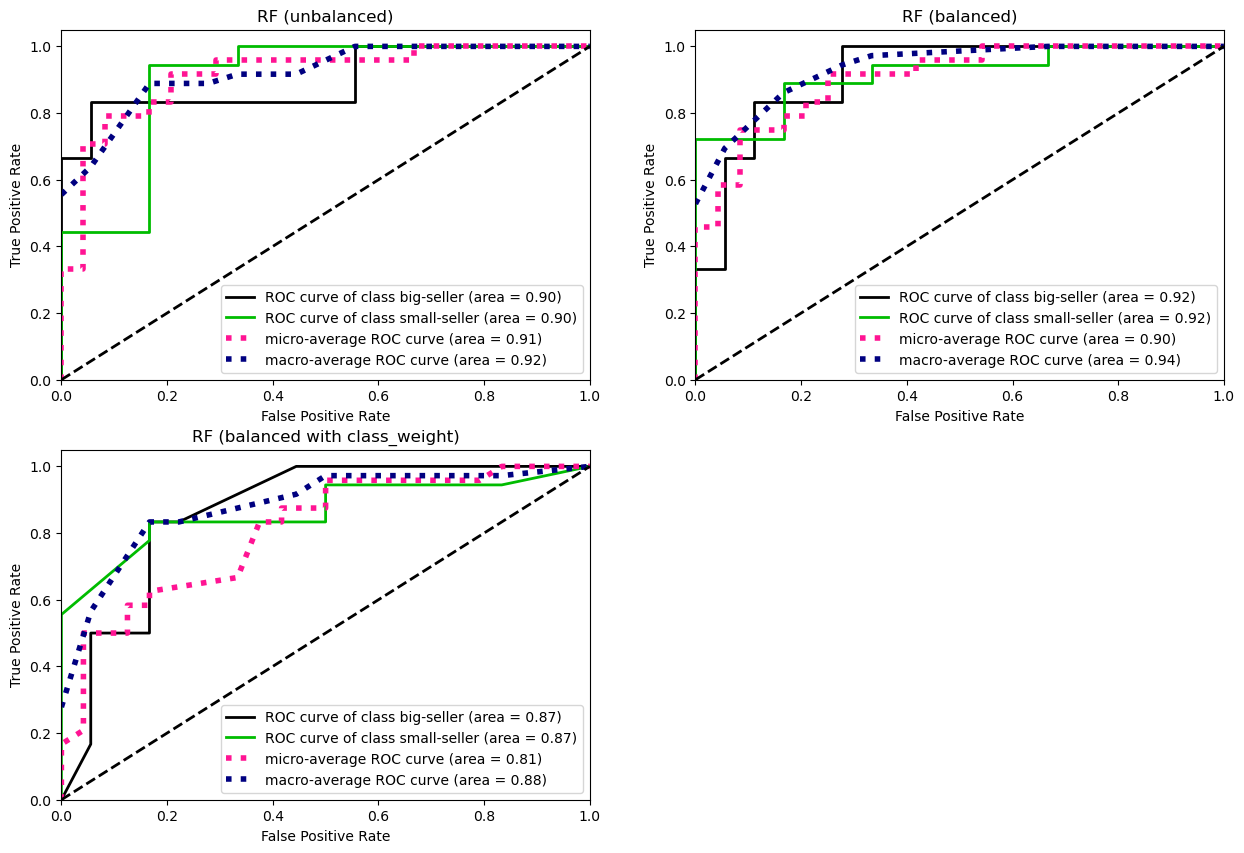

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_unb, title="RF (unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_bal, title="RF (balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_wei, title="RF (balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

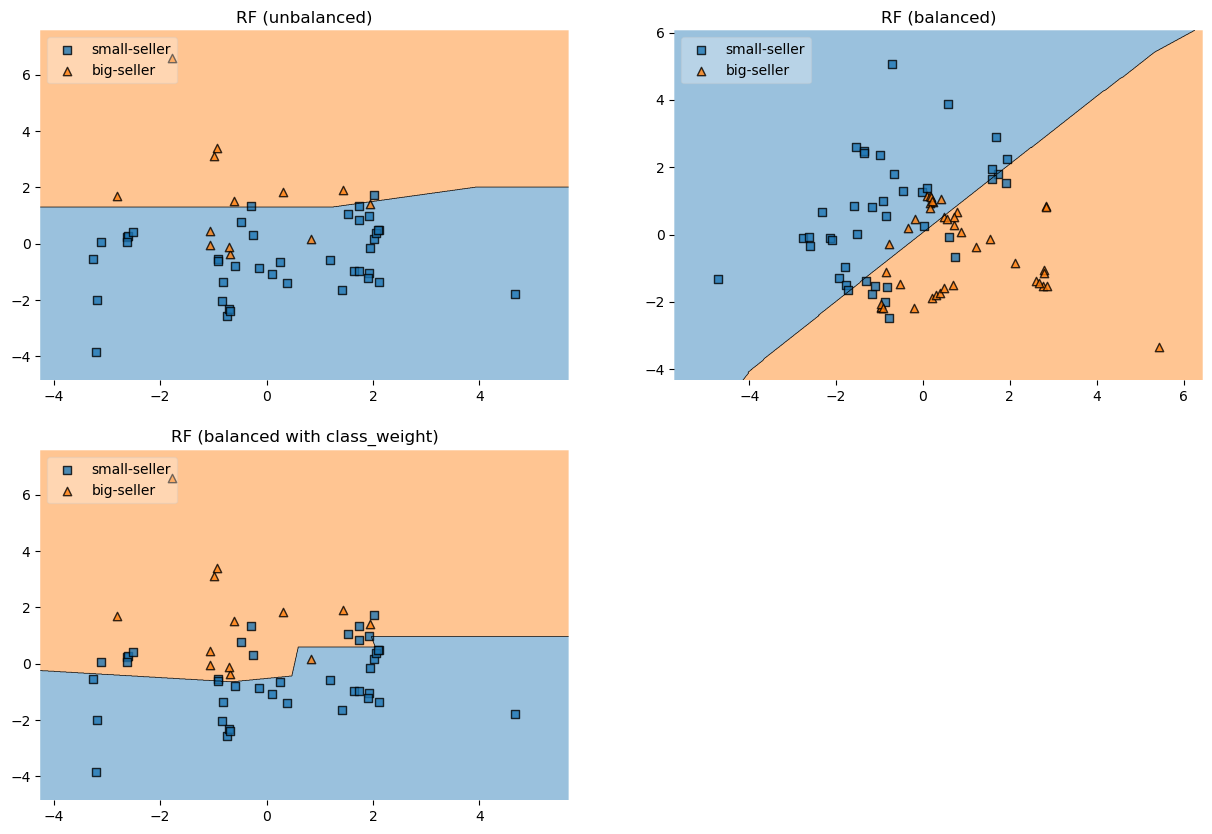

In [69]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [rf_unb, rf_bal, rf_wei], ["RF (unbalanced)", "RF (balanced)", "RF (balanced with class_weight)"])

### Conclusions
The model trained using class_weight offers better results.  
Its interesting to note how much more jagged the decision boundary is in this case compared to the unbalanced one,

## K-Nearest Neighbour
For the number of neighbours to query we use the sqrt(number of features) heuristic.

### Parameter search and fitting

#### Unbalanced classes

In [70]:
#define the parameters' values you want to try
param_dist_knn = {
    'n_neighbors': [int(np.ceil(np.sqrt(pred_df.shape[1])))],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }
#define the model
clf = KNeighborsClassifier()
#define the grid search
grid_search_knn_unb = RandomizedSearchCV(clf, param_distributions=param_dist_knn,
                            n_jobs=-1,
                            n_iter=12,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_knn_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_knn_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_knn_unb.cv_results_['mean_test_score'][0], 
      grid_search_knn_unb.cv_results_['std_test_score'][0])


knn_unb = KNeighborsClassifier(**grid_search_knn_unb.best_params_).fit(train_set, train_label)

test_pred_knn_unb = knn_unb.predict(test_set)
test_pred_proba_knn_unb = knn_unb.predict_proba(test_set)

Best settings parameters  {'weights': 'uniform', 'n_neighbors': 4, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Setting's accuracy score mean and std  0.7618181818181818 0.10670109637179064


#### Balanced classes

In [71]:
#define the parameters' values you want to try
param_dist_knn = {
    'n_neighbors': [int(np.ceil(np.sqrt(pred_df.shape[1])))],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }
#define the model
clf = KNeighborsClassifier()
#define search
grid_search_knn_bal = RandomizedSearchCV(clf, param_distributions=param_dist_knn,
                            n_jobs=-1,
                            n_iter=12,
                            scoring=make_scorer(accuracy_score))
#run the search
grid_search_knn_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_knn_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_knn_bal.cv_results_['mean_test_score'][0], 
      grid_search_knn_bal.cv_results_['std_test_score'][0])

#Actual model fitting
knn_bal = KNeighborsClassifier(**grid_search_knn_bal.best_params_).fit(train_set_bal, train_label_bal)

test_pred_knn_bal = knn_bal.predict(test_set)
test_pred_proba_knn_bal = knn_bal.predict_proba(test_set)

Best settings parameters  {'weights': 'uniform', 'n_neighbors': 4, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Setting's accuracy score mean and std  0.7470588235294118 0.165226985530224


### Evaluation

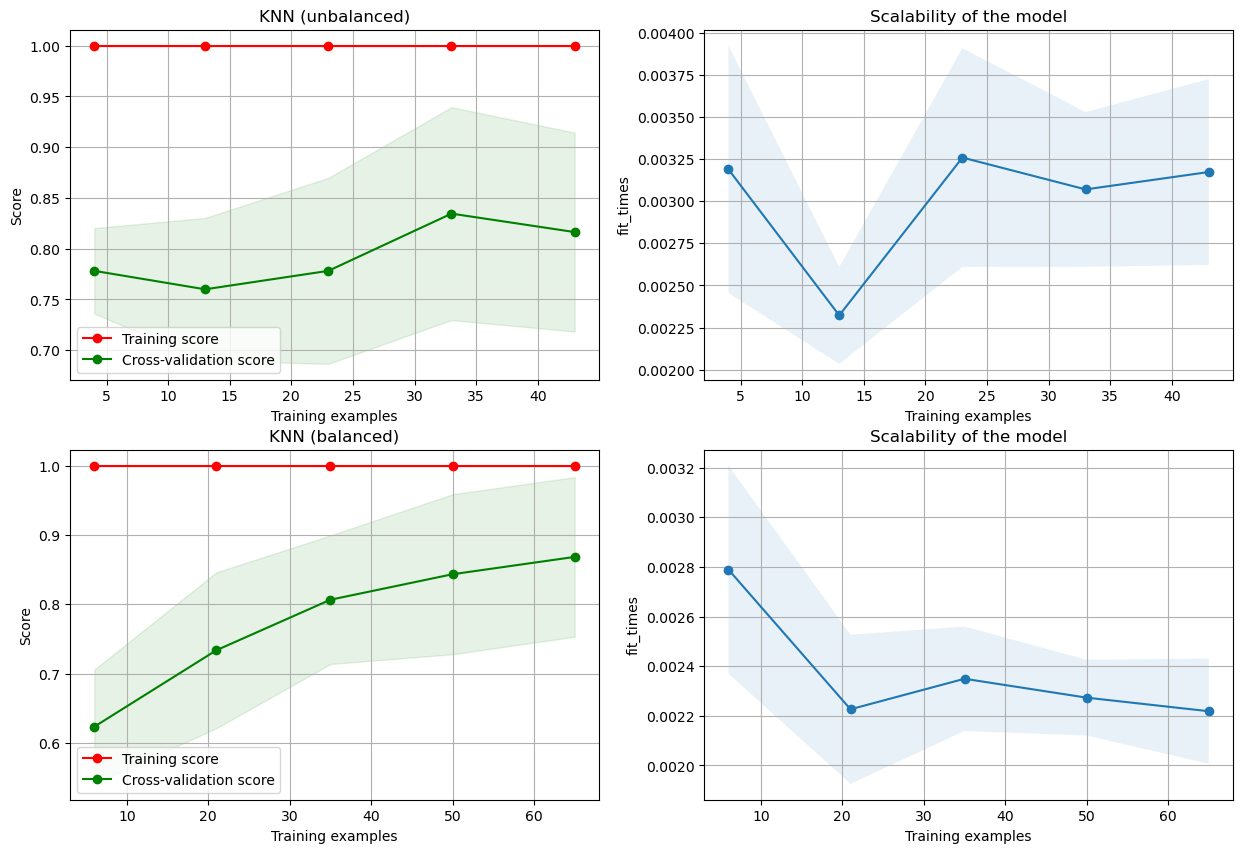

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_learning_curve(knn_unb, "KNN (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(knn_bal, "KNN (balanced)", train_set_bal, train_label_bal, ax=axes[1])

plt.show()

In [73]:
print("KNN (unbalanced)")
report_scores(test_label,test_pred_knn_unb)
print("\n")
print("KNN (balanced)")
report_scores(test_label,test_pred_knn_bal)

KNN (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.62      0.83      0.71         6
small-seller       0.94      0.83      0.88        18

    accuracy                           0.83        24
   macro avg       0.78      0.83      0.80        24
weighted avg       0.86      0.83      0.84        24



KNN (balanced)
              precision    recall  f1-score   support

  big-seller       0.46      1.00      0.63         6
small-seller       1.00      0.61      0.76        18

    accuracy                           0.71        24
   macro avg       0.73      0.81      0.70        24
weighted avg       0.87      0.71      0.73        24



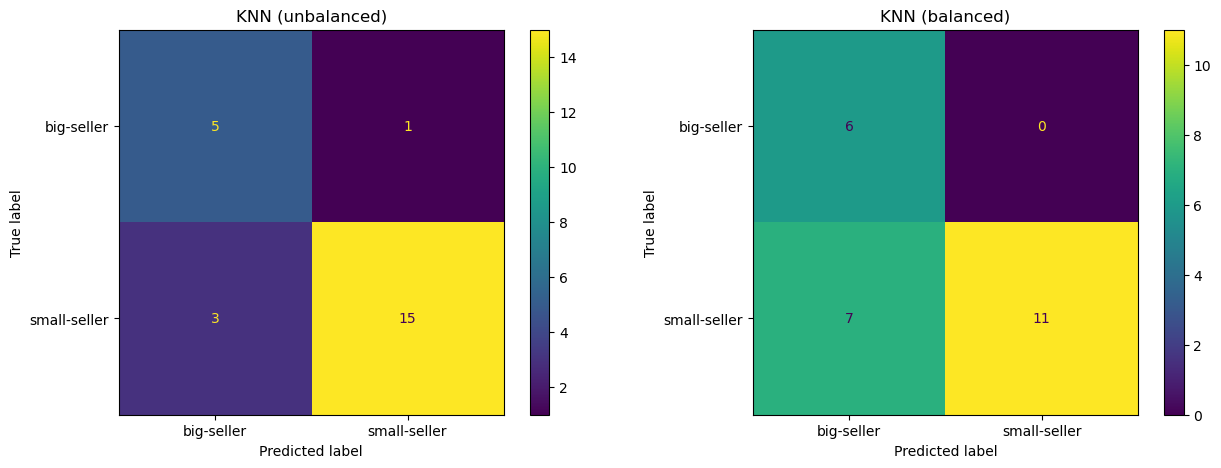

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("KNN (unbalanced)")
plot_confusion_matrix(knn_unb, test_set, test_label, ax=axes[0])
axes[1].set_title("KNN (balanced)")
plot_confusion_matrix(knn_bal, test_set, test_label, ax=axes[1])
plt.show() 

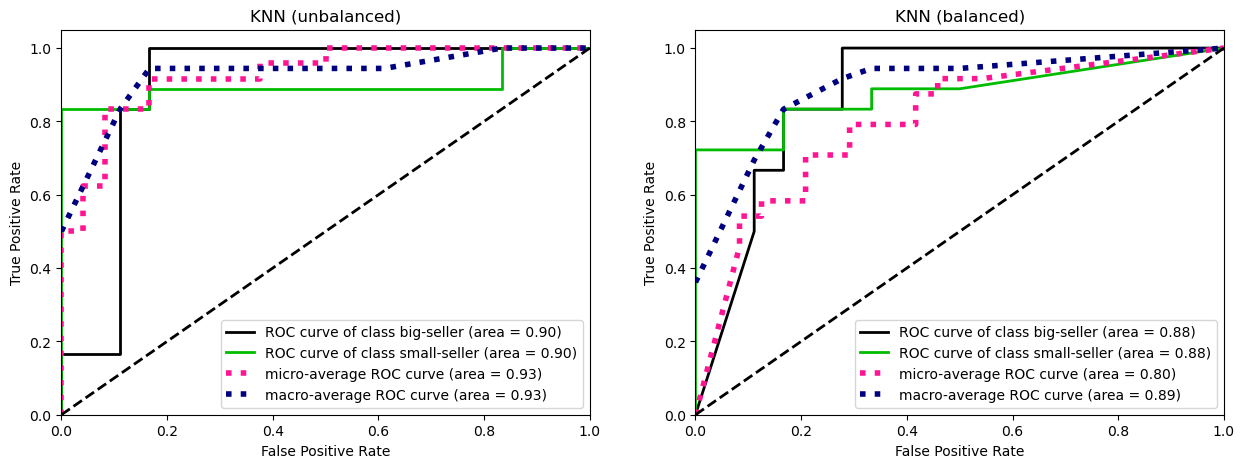

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_knn_unb, title="KNN (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_knn_bal, title="KNN (balanced)", ax=axes[1])
plt.show()

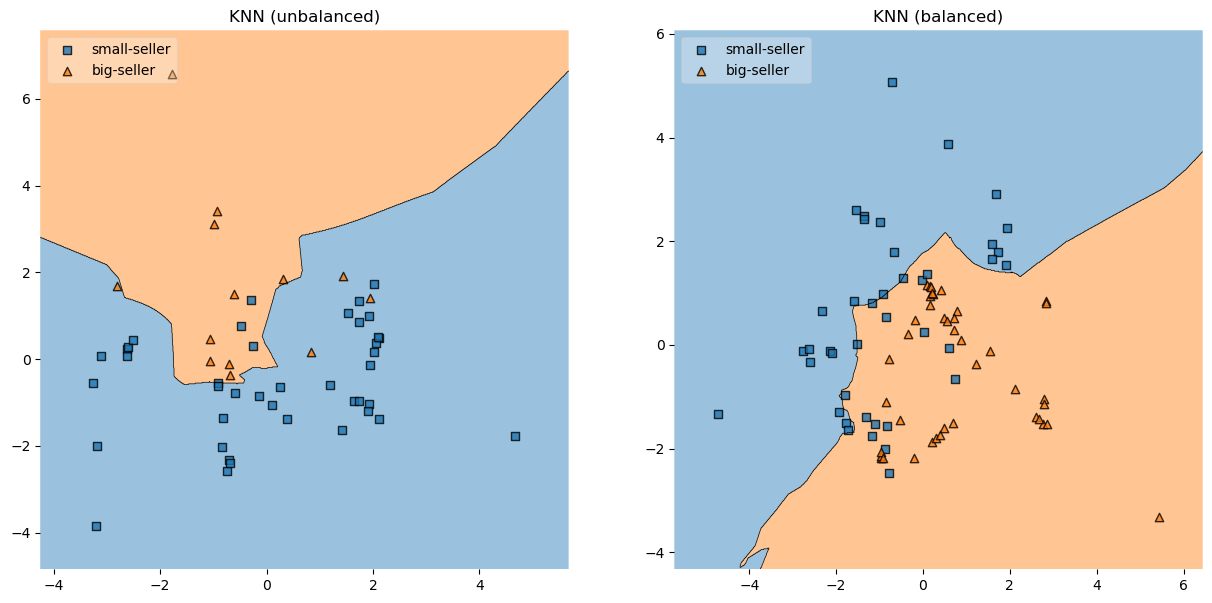

In [76]:
plot_decision_boundary([train_set, train_set_bal], [train_label, train_label_bal], \
                       [knn_unb, knn_bal], ["KNN (unbalanced)", "KNN (balanced)"])

### Conclusions
We can see that with KNN having a balanced number of classes has a mixed impact on the results, depending on the usecase one model can be preferred over the other (ie if we care about identifying with certainty that a vendor is small we can use the second model)

## SVM
We will consider two different kernels (linear and rbf) and compare their performance.

### Linear

#### Unbalanced

In [77]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_unb = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_lin_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_unb.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_unb.cv_results_['std_test_score'][0])


svm_lin_unb = SVC(**grid_search_svm_lin_unb.best_params_)
svm_lin_unb.fit(train_set, train_label)

test_pred_proba_svm_lin_unb = svm_lin_unb.predict_proba(test_set)
test_pred_svm_lin_unb = svm_lin_unb.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'C': 752.7552252252253}
Setting's accuracy score mean and std  0.909090909090909 0.08131156281817416


#### Balanced

In [78]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_bal = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_svm_lin_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_bal.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_bal.cv_results_['std_test_score'][0])


svm_lin_bal = SVC(**grid_search_svm_lin_bal.best_params_)
svm_lin_bal.fit(train_set_bal, train_label_bal)

test_pred_proba_svm_lin_bal = svm_lin_bal.predict_proba(test_set)
test_pred_svm_lin_bal = svm_lin_bal.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'C': 76.08531531531533}
Setting's accuracy score mean and std  0.9522058823529411 0.04424002634262155


#### Balanced with class_weight

In [79]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000), 
    "class_weight": ["balanced"]
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_wei = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_lin_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_wei.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_wei.cv_results_['std_test_score'][0])


svm_lin_wei = SVC(**grid_search_svm_lin_wei.best_params_)
svm_lin_wei.fit(train_set, train_label)

test_pred_proba_svm_lin_wei = svm_lin_wei.predict_proba(test_set)
test_pred_svm_lin_wei = svm_lin_wei.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 580.5847747747748}
Setting's accuracy score mean and std  0.909090909090909 0.08131156281817416


#### Evaluation

In [80]:
print("SVM (Linear, unbalanced)")
report_scores(test_label, test_pred_svm_lin_unb)
print("\n")
print("SVM (Linear, balanced)")
report_scores(test_label, test_pred_svm_lin_bal)
print("\n")
print("SVM (Linear, balanced with class_weight)")
report_scores(test_label, test_pred_svm_lin_wei)

SVM (Linear, unbalanced)
              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



SVM (Linear, balanced)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



SVM (Linear, balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86  

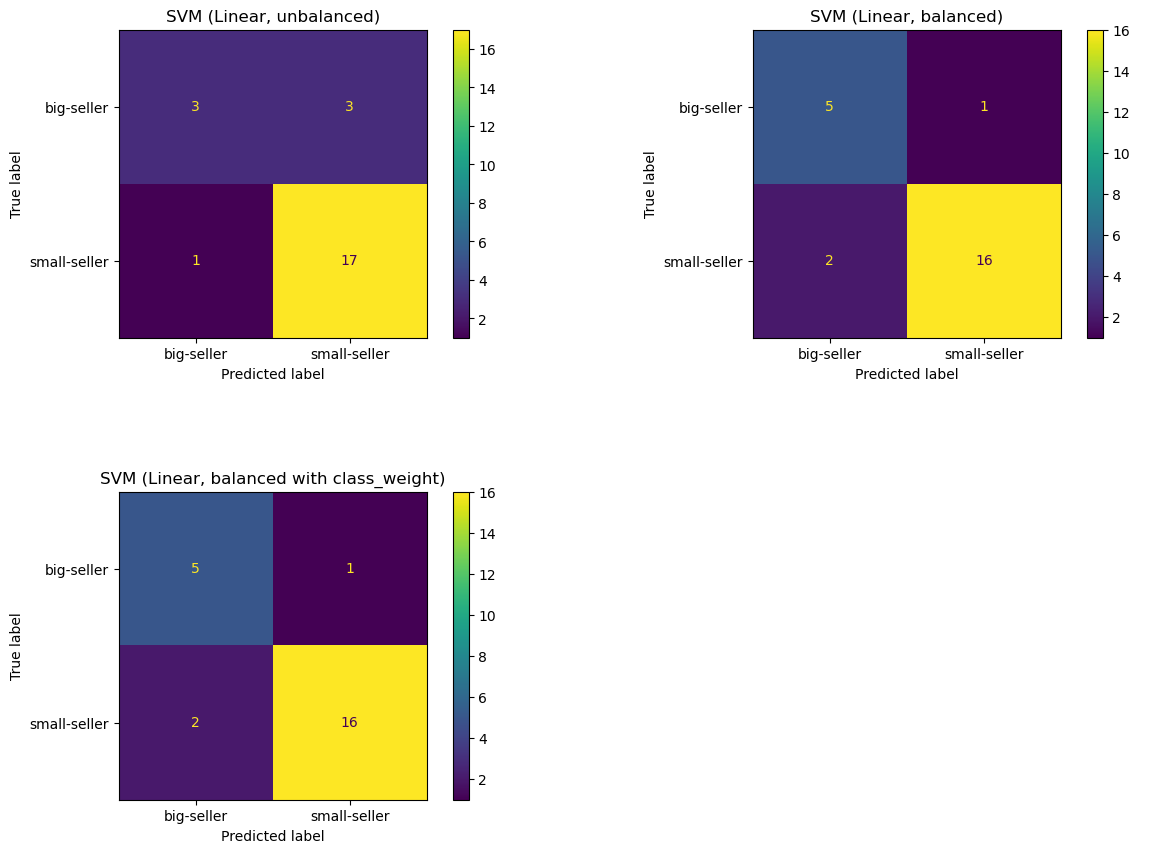

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("SVM (Linear, unbalanced)")
plot_confusion_matrix(svm_lin_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("SVM (Linear, balanced)")
plot_confusion_matrix(svm_lin_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("SVM (Linear, balanced with class_weight)")
plot_confusion_matrix(svm_lin_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

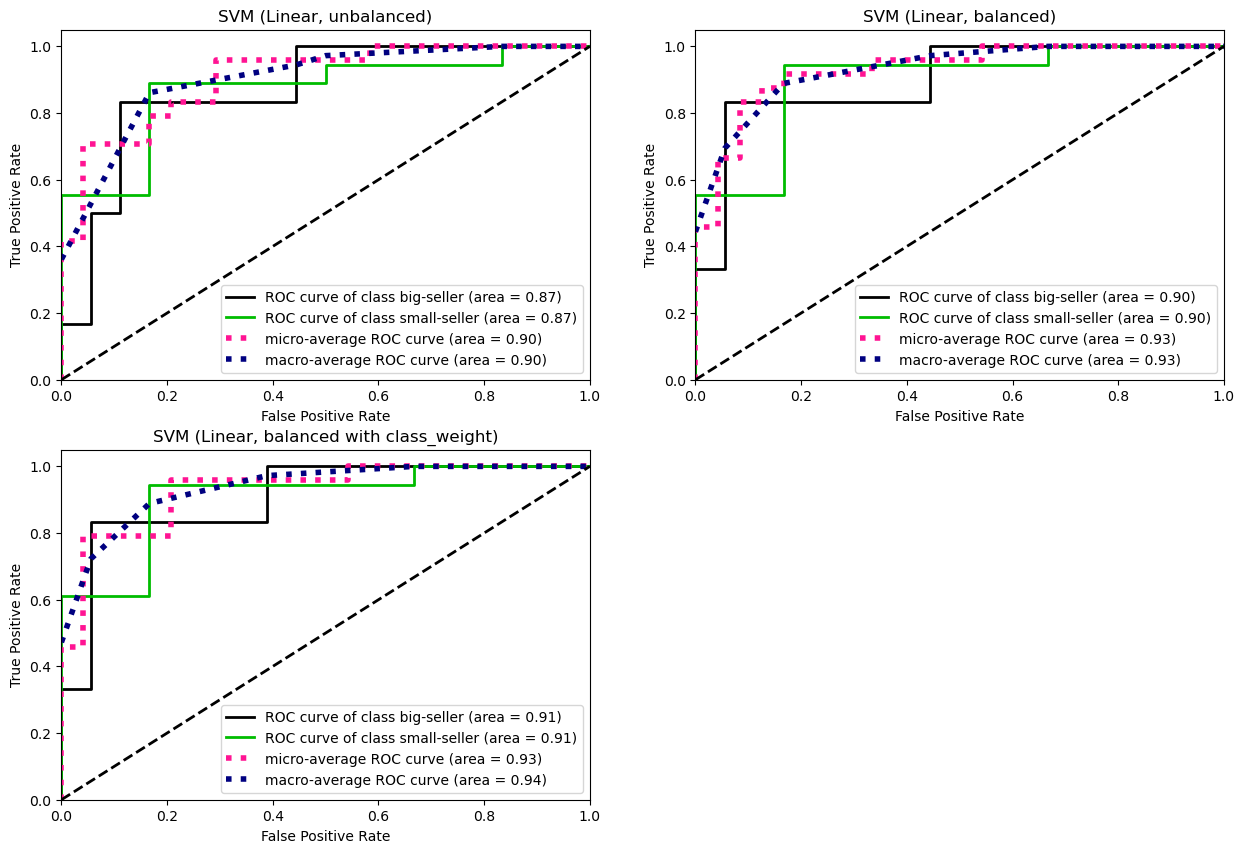

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_unb, title="SVM (Linear, unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_bal, title="SVM (Linear, balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_wei, title="SVM (Linear, balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

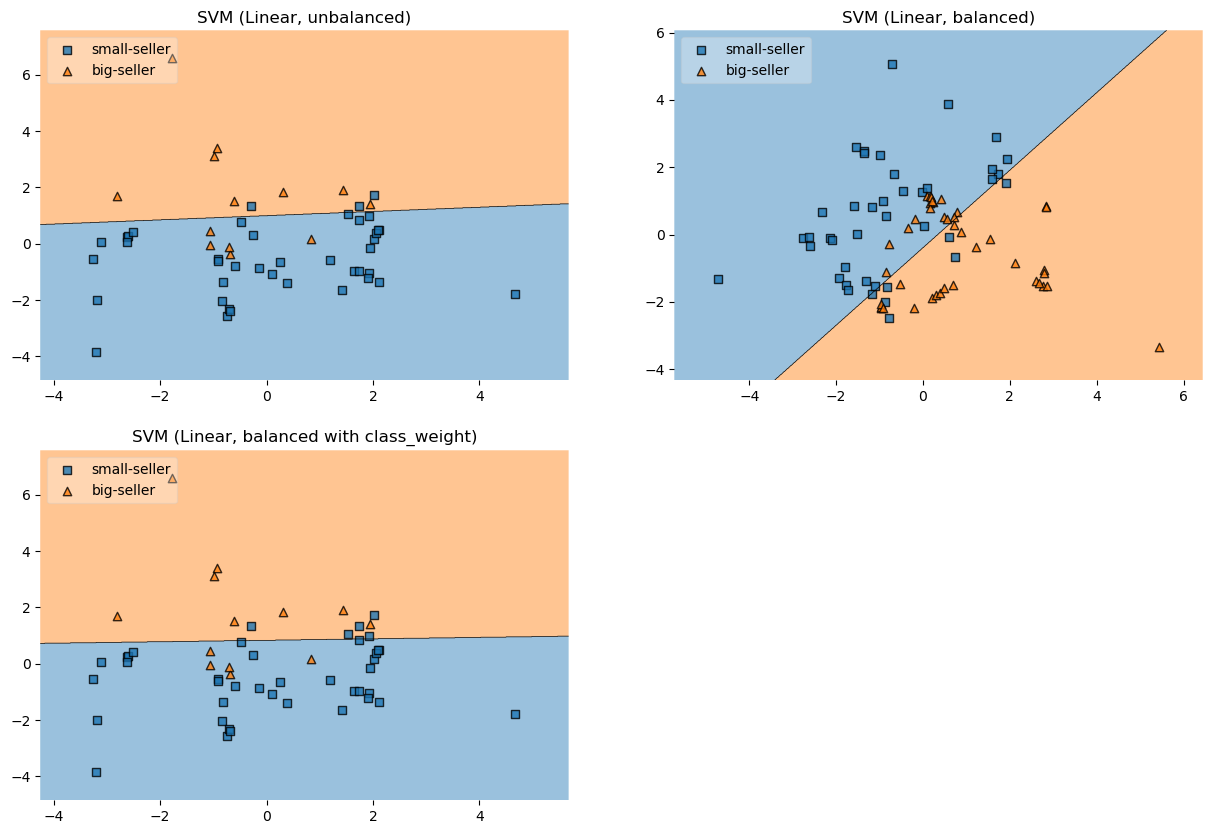

In [83]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [svm_lin_unb, svm_lin_bal, svm_lin_wei], \
                       ["SVM (Linear, unbalanced)", "SVM (Linear, balanced)", "SVM (Linear, balanced with class_weight)"])

#### Conclusions
The results of the models trained on balanced datasets are better across the board.

### RBF

#### Unbalanced

In [84]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_unb = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_rbf_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_unb.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_unb.cv_results_['std_test_score'][0])


svm_rbf_unb = SVC(**grid_search_svm_rbf_unb.best_params_)
svm_rbf_unb.fit(train_set, train_label)

test_pred_proba_svm_rbf_unb = svm_rbf_unb.predict_proba(test_set)
test_pred_svm_rbf_unb = svm_rbf_unb.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'C': 717.7205405405406}
Setting's accuracy score mean and std  0.8345454545454546 0.10482571131199689


#### Balanced

In [85]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_bal = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_svm_rbf_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_bal.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_bal.cv_results_['std_test_score'][0])


svm_rbf_bal = SVC(**grid_search_svm_rbf_bal.best_params_)
svm_rbf_bal.fit(train_set_bal, train_label_bal)

test_pred_proba_svm_rbf_bal = svm_rbf_bal.predict_proba(test_set)
test_pred_svm_rbf_bal = svm_rbf_bal.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'C': 772.7750450450451}
Setting's accuracy score mean and std  0.9286764705882353 0.06848900601291188


#### Balanced with class_weight

In [86]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000), 
    "class_weight": ["balanced"]
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_wei = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_rbf_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_wei.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_wei.cv_results_['std_test_score'][0])


svm_rbf_wei = SVC(**grid_search_svm_rbf_wei.best_params_)
svm_rbf_wei.fit(train_set, train_label)

test_pred_proba_svm_rbf_wei = svm_rbf_wei.predict_proba(test_set)
test_pred_svm_rbf_wei = svm_rbf_wei.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 190.1982882882883}
Setting's accuracy score mean and std  0.8345454545454546 0.10482571131199689


In [87]:
print("SVM (RBF, unbalanced)")
report_scores(test_label, test_pred_svm_rbf_unb)
print("\n")
print("SVM (RBF, balanced)")
report_scores(test_label, test_pred_svm_rbf_bal)
print("\n")
print("SVM (RBF, balanced with class_weight)")
report_scores(test_label, test_pred_svm_rbf_wei)

SVM (RBF, unbalanced)
              precision    recall  f1-score   support

  big-seller       0.60      0.50      0.55         6
small-seller       0.84      0.89      0.86        18

    accuracy                           0.79        24
   macro avg       0.72      0.69      0.71        24
weighted avg       0.78      0.79      0.79        24



SVM (RBF, balanced)
              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



SVM (RBF, balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84 

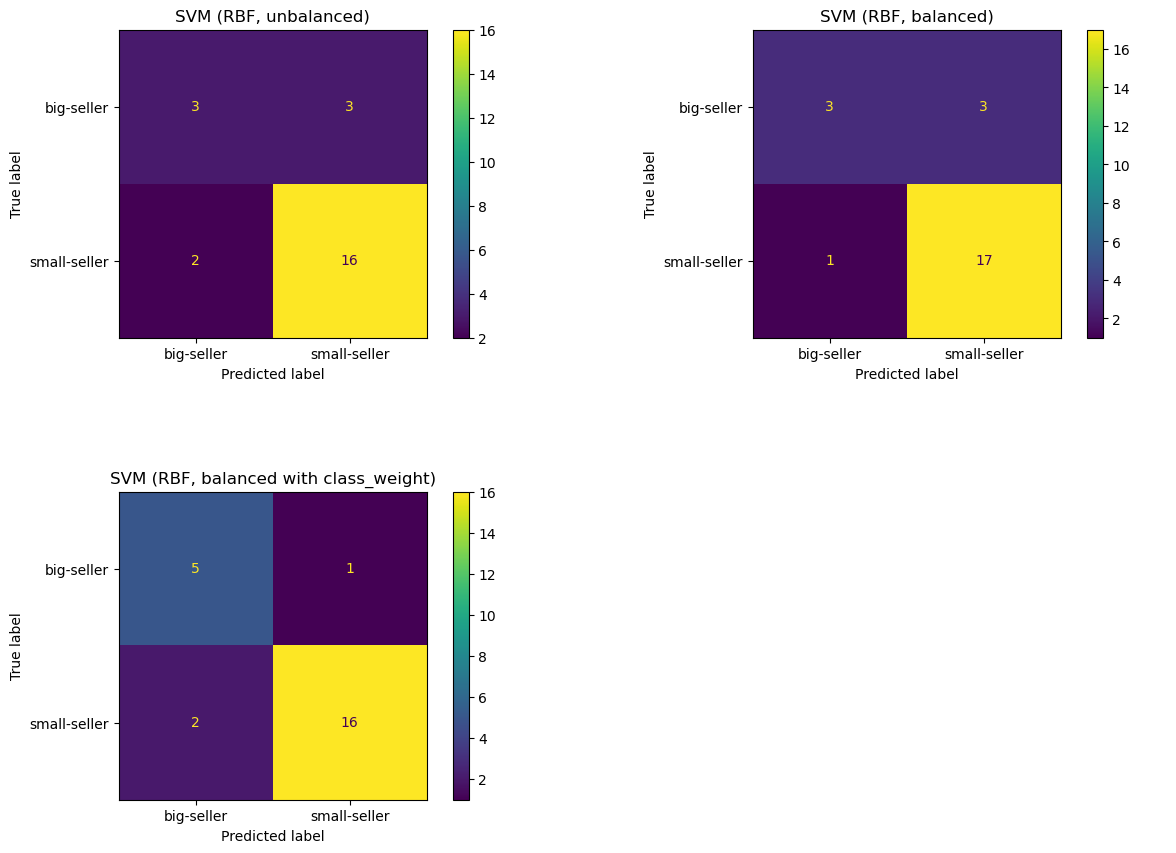

In [88]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("SVM (RBF, unbalanced)")
plot_confusion_matrix(svm_rbf_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("SVM (RBF, balanced)")
plot_confusion_matrix(svm_rbf_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("SVM (RBF, balanced with class_weight)")
plot_confusion_matrix(svm_rbf_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

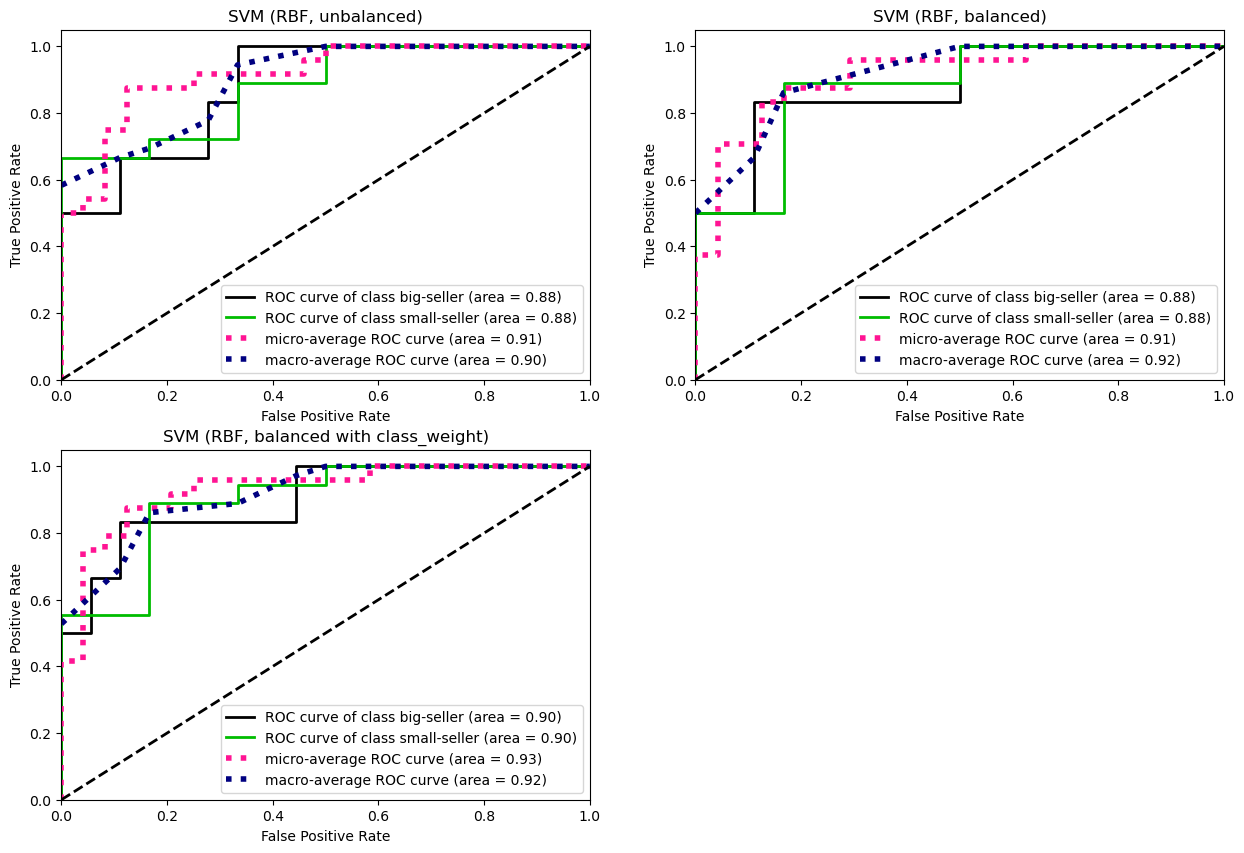

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_unb, title="SVM (RBF, unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_bal, title="SVM (RBF, balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_wei, title="SVM (RBF, balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

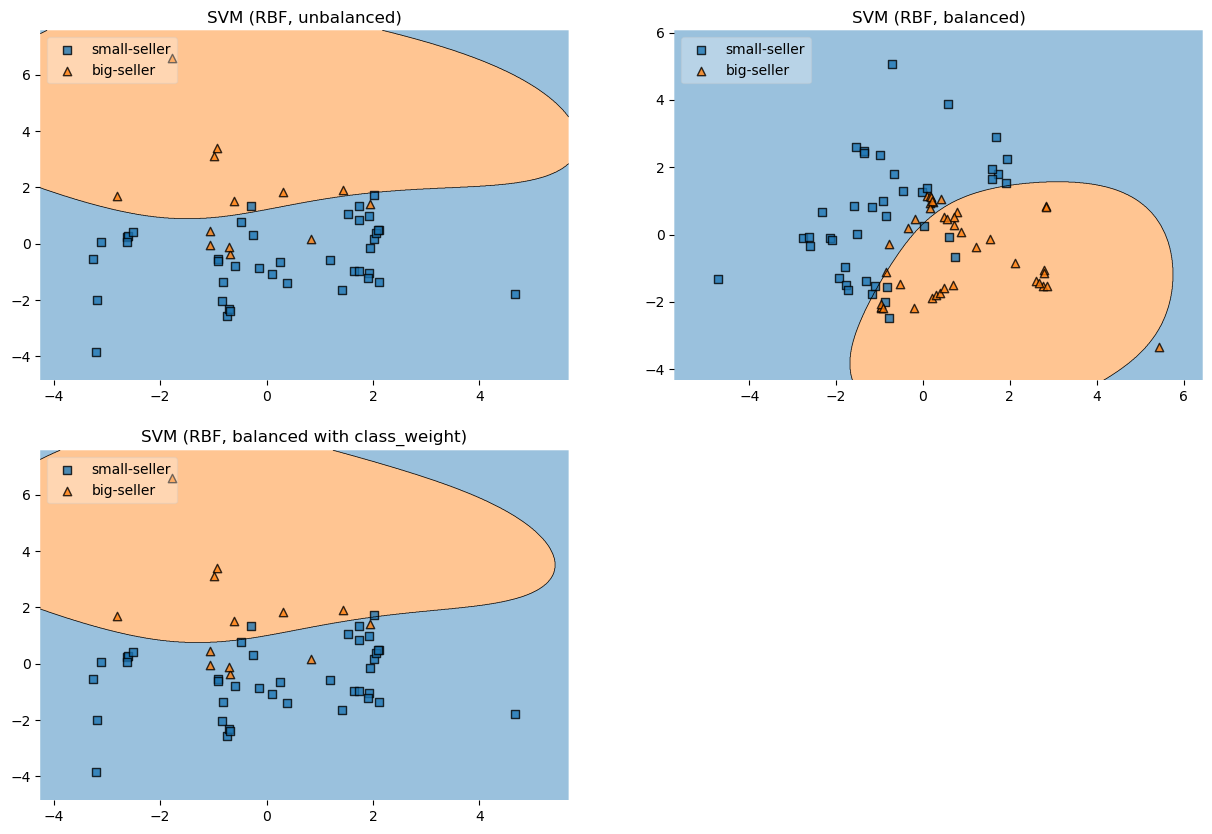

In [90]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [svm_rbf_unb, svm_rbf_bal, svm_rbf_wei], \
                       ["SVM (RBF, unbalanced)", "SVM (RBF, balanced)", "SVM (RBF, balanced with class_weight)"])

#### Conclusions
Here the best model is the one trained on the unbalanced dataset.  
This time there was a significant difference between the results obtained from the balanced dataset and the use of class_weight.

### Kernel comparison

In [91]:
print("SVM (Linear, balanced)")
report_scores(test_label, test_pred_svm_lin_bal)
print("\n")
print("SVM (RBF, balanced with class_weight)")
report_scores(test_label, test_pred_svm_rbf_wei)

SVM (Linear, balanced)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



SVM (RBF, balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



The two kernels offer identical results.

## Rule-based classification (Ripper)

In [92]:
#Ripper's fit method requires a single containing the labels
rip_data_unb = pd.concat([train_set, train_label], axis=1)
rip_data_bal = pd.concat([train_set_bal, train_label_bal], axis=1)

### Unbalanced

In [93]:
clf = RIPPER()

param_grid_rip = {"prune_size": np.linspace(0.1, 1, 10), 
              "k": range(2, 10)}

grid_search_rip_unb = RandomizedSearchCV(estimator=clf, 
                                     n_iter=50,
                                     param_distributions=param_grid_rip)

grid_search_rip_unb.fit(train_set, train_label, pos_class="big-seller")

print('Best parameters setting ', grid_search_rip_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rip_unb.cv_results_['mean_test_score'][0], 
      grid_search_rip_unb.cv_results_['std_test_score'][0])


#define and fit the rule-based model
ripper_unb = RIPPER(**grid_search_rip_unb.best_params_)
ripper_unb.fit(rip_data_unb, class_feat='Label', pos_class="big-seller")

test_pred_rip_unb = ripper_unb.predict(test_set, give_reasons=True)
test_pred_proba_rip_unb = ripper_unb.predict_proba(test_set)

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

Best parameters setting  {'prune_size': 0.2, 'k': 2}
Setting's accuracy score mean and std  0.6690909090909092 0.1844894675485938


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [0]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



In [94]:
print(ripper_unb.ruleset_)

[Eram=1.34-2.17] V [Eram=0.15-0.4] V [Eram=0.56-1.34^TopSalesMonth=0.57-1.1]


### Balanced

In [95]:
clf = RIPPER()

param_grid_rip = {"prune_size": np.linspace(0.1, 1, 10), 
              "k": range(2, 10)}

grid_search_rip_bal = RandomizedSearchCV(estimator=clf, 
                                     n_iter=50,
                                     param_distributions=param_grid_rip)

grid_search_rip_bal.fit(train_set_bal, train_label_bal, pos_class="big-seller")

print('Best parameters setting ', grid_search_rip_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rip_bal.cv_results_['mean_test_score'][0], 
      grid_search_rip_bal.cv_results_['std_test_score'][0])


#define and fit the rule-based model
ripper_bal = RIPPER(**grid_search_rip_bal.best_params_)
ripper_bal.fit(rip_data_unb, class_feat='Label', pos_class="big-seller")

test_pred_rip_bal = ripper_bal.predict(test_set, give_reasons=True)
test_pred_proba_rip_bal = ripper_bal.predict_proba(test_set)

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

Best parameters setting  {'prune_size': 0.8, 'k': 2}
Setting's accuracy score mean and std  0.6742647058823529 0.15895963666907834


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [0]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



In [96]:
print(ripper_bal.ruleset_)

[Eram=1.34-2.17] V [Eram=0.15-0.4]


### Evaluation

In [97]:
#Ripper's implementation doesn't output the vendor label but true or false
train_label_rip = train_label.replace({"big-seller":True, "small-seller":False})
train_label_bal_rip = train_label_bal.replace({"big-seller":True, "small-seller":False})
test_label_rip = test_label.replace({"big-seller":True, "small-seller":False})

In [98]:
print("Ripper (unbalanced)")
print(classification_report(test_label_rip, test_pred_rip_unb[0], target_names=['small-seller', 'big-seller']))
print("\n")
print("Ripper (balanced)")
print(classification_report(test_label_rip, test_pred_rip_bal[0], target_names=['small-seller', 'big-seller']))

Ripper (unbalanced)
              precision    recall  f1-score   support

small-seller       0.75      0.67      0.71        18
  big-seller       0.25      0.33      0.29         6

    accuracy                           0.58        24
   macro avg       0.50      0.50      0.50        24
weighted avg       0.62      0.58      0.60        24



Ripper (balanced)
              precision    recall  f1-score   support

small-seller       0.75      0.67      0.71        18
  big-seller       0.25      0.33      0.29         6

    accuracy                           0.58        24
   macro avg       0.50      0.50      0.50        24
weighted avg       0.62      0.58      0.60        24



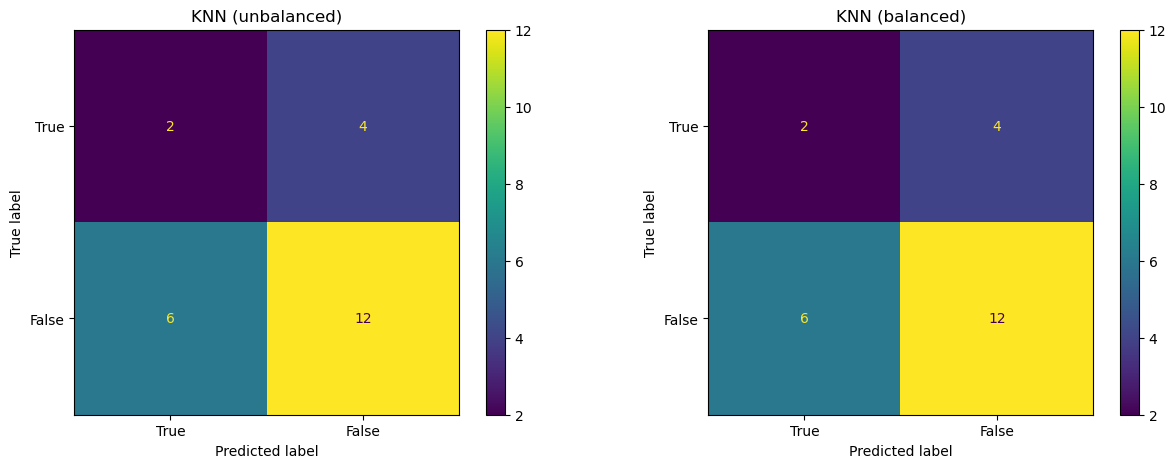

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("KNN (unbalanced)")
plot_confusion_matrix(ripper_unb, test_set, test_label_rip, ax=axes[0], labels=(True, False))
axes[1].set_title("KNN (balanced)")
plot_confusion_matrix(ripper_bal, test_set, test_label_rip, ax=axes[1], labels=(True, False))
plt.show() 

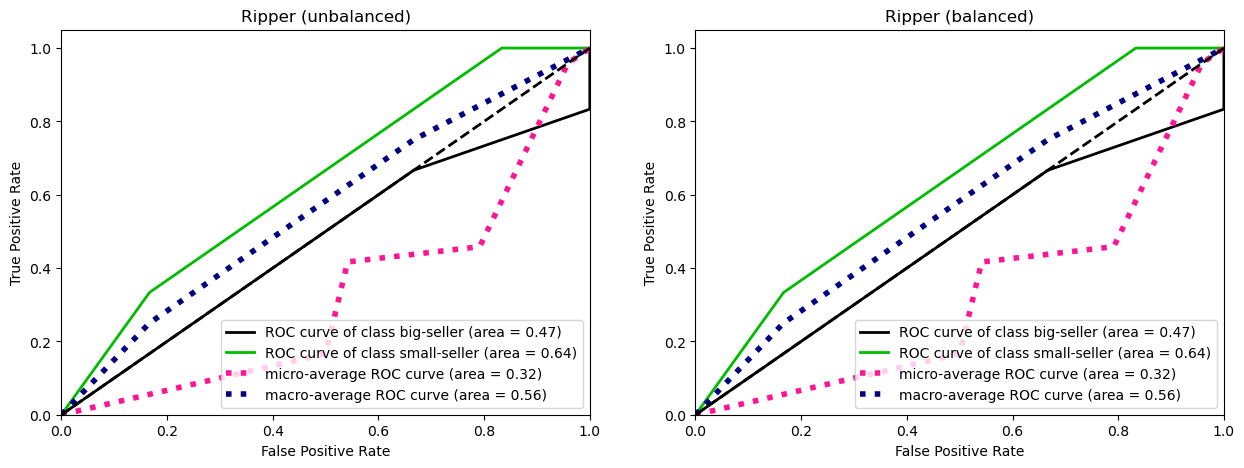

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_rip_unb, title="Ripper (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rip_bal, title="Ripper (balanced)", ax=axes[1])
plt.show()

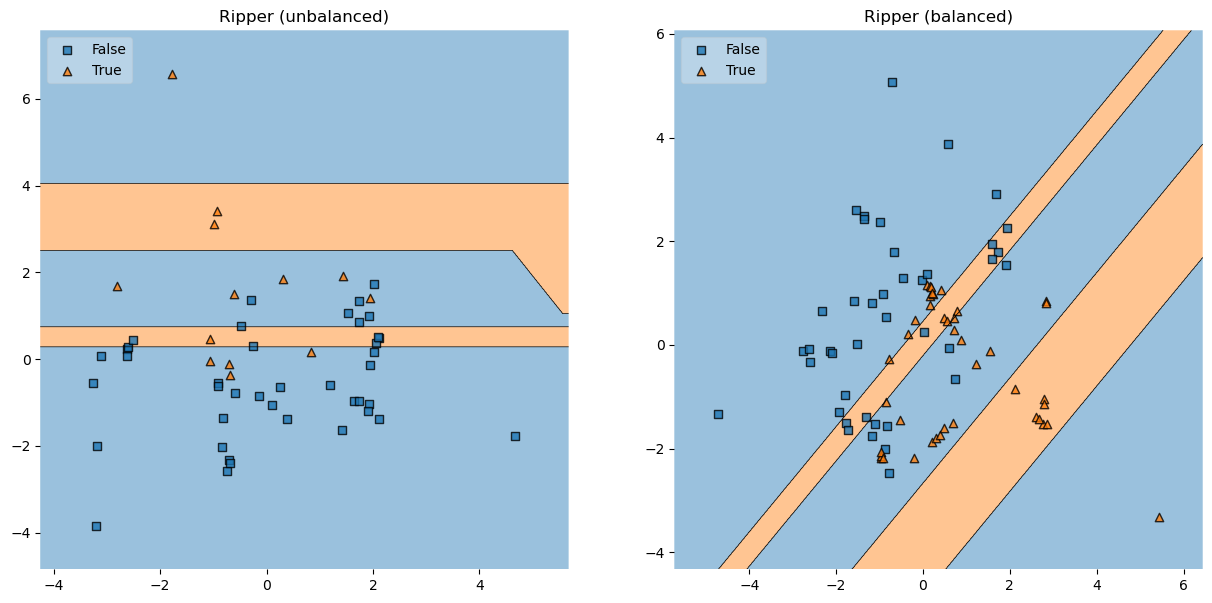

In [101]:
plot_decision_boundary([train_set, train_set_bal], [train_label_rip, train_label_bal_rip], \
                       [ripper_unb, ripper_bal], ["Ripper (unbalanced)", "Ripper (balanced)"], label_dict={True:1, False:0})

The boundary are really interesting to look at, unfortunately they don't seem to fit the data well.

### Conclusions

Ripper doesn't perform too well on this dataset, probably due to the low amount of datapoints.  
In this case the balanced dataset makes the model more selective (increased precision/decreased recall) about which entries it considers big-sellers.

## Multi-layer Perceptron  
Just for comparison purposes, we don't expect an MLP to outperform the other models having such a small dataset.

### Unbalanced classes

In [102]:
param_dist_mlp = {
    'solver': ["sgd", "adam", "lbfgs"],
    'alpha': [0.0001, 0.001],
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(x,) for x in range(1, 20, 5)],
    'early_stopping': [True, False]
}

clf = MLPClassifier()
grid_search_mlp_unb = GridSearchCV(clf, param_grid=param_dist_mlp,
                            n_jobs=4,
                            scoring=make_scorer(accuracy_score))

grid_search_mlp_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_mlp_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_mlp_unb.cv_results_['mean_test_score'][0], 
      grid_search_mlp_unb.cv_results_['std_test_score'][0])


mlp_unb = MLPClassifier(**grid_search_mlp_unb.best_params_).fit(train_set, train_label)

test_pred_mlp_unb = mlp_unb.predict(test_set)
test_pred_proba_mlp_unb = mlp_unb.predict_proba(test_set)

Best settings parameters  {'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'solver': 'sgd'}
Setting's accuracy score mean and std  0.4581818181818182 0.20259473857722354


### Balanced classes

In [103]:
param_dist_mlp = {
    'solver': ["sgd", "adam", "lbfgs"],
    'alpha': [0.0001, 0.001],
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(x,) for x in range(1, 20, 5)],
    'early_stopping': [True, False]
}

clf = MLPClassifier()
grid_search_mlp_bal = GridSearchCV(clf, param_grid=param_dist_mlp,
                            n_jobs=4,
                            scoring=make_scorer(accuracy_score))

grid_search_mlp_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_mlp_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_mlp_bal.cv_results_['mean_test_score'][0], 
      grid_search_mlp_bal.cv_results_['std_test_score'][0])


mlp_bal = MLPClassifier(**grid_search_mlp_bal.best_params_).fit(train_set_bal, train_label_bal)

test_pred_mlp_bal = mlp_bal.predict(test_set)
test_pred_proba_mlp_bal = mlp_bal.predict_proba(test_set)

Best settings parameters  {'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'solver': 'sgd'}
Setting's accuracy score mean and std  0.4992647058823529 0.03356680061915685


### Evaluation

In [104]:
print("MLP (unbalanced)")
report_scores(test_label, test_pred_mlp_unb)
print("\n")
print("MLP (balanced)")
report_scores(test_label, test_pred_mlp_bal)

MLP (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



MLP (balanced)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



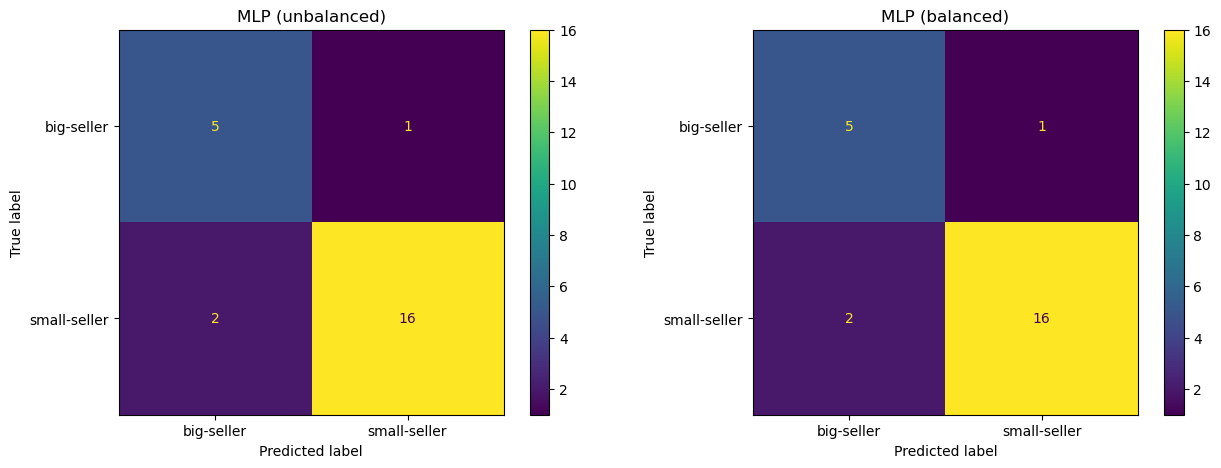

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("MLP (unbalanced)")
plot_confusion_matrix(mlp_unb, test_set, test_label, ax=axes[0])
axes[1].set_title("MLP (balanced)")
plot_confusion_matrix(mlp_bal, test_set, test_label, ax=axes[1])
plt.show() 

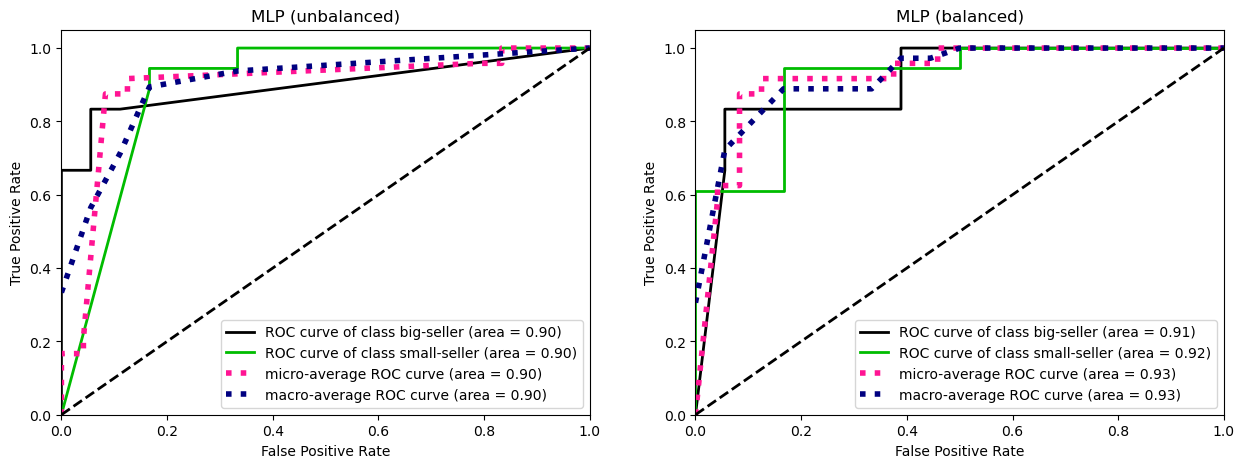

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_mlp_unb, title="MLP (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_mlp_bal, title="MLP (balanced)", ax=axes[1])
plt.show()

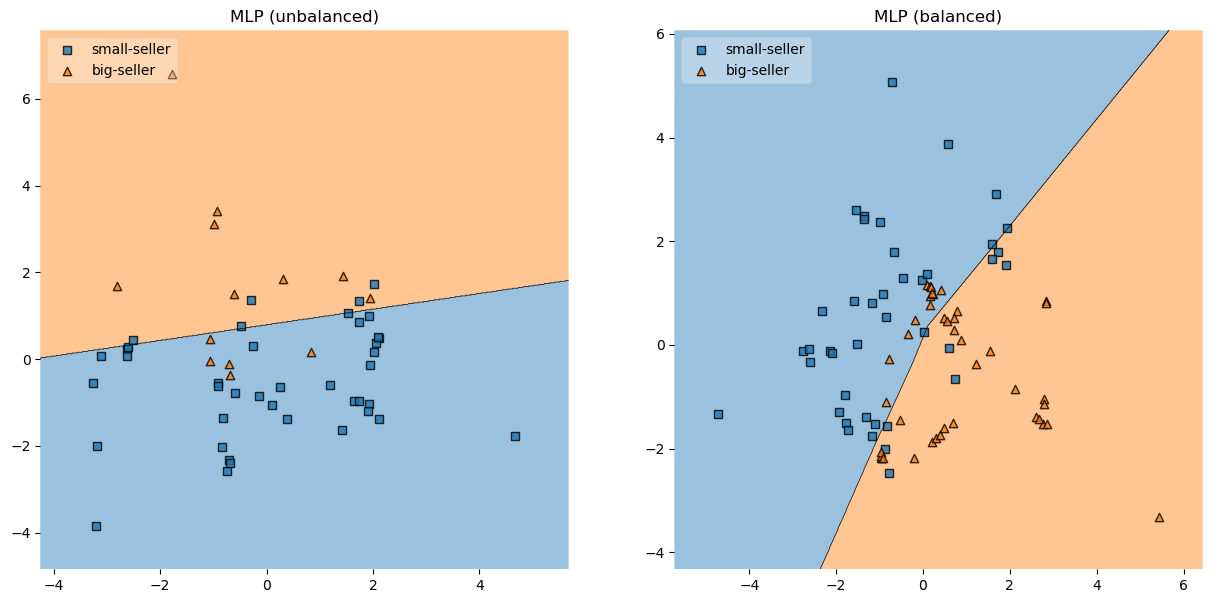

In [107]:
plot_decision_boundary([train_set, train_set_bal], [train_label, train_label_bal], \
                       [mlp_unb, mlp_bal], ["MLP (unbalanced)", "MLP (balanced)"])

### Conclusions
The results are still remarkable and probably among the best.  

## Results recap
Following are the best results from each classifier.

In [108]:
model_dict = {"DT (unbalanced, pruned)":dt_unb_post, "GaussianNB (balanced)":gnb_bal, "RF (balanced with class_weight)":rf_wei, \
              "KNN (unbalanced)":knn_unb, "SVM (Linear, balanced)":svm_lin_bal, "Ripper (unbalanced)":ripper_unb, \
              "MLP (unbalanced)":mlp_unb}

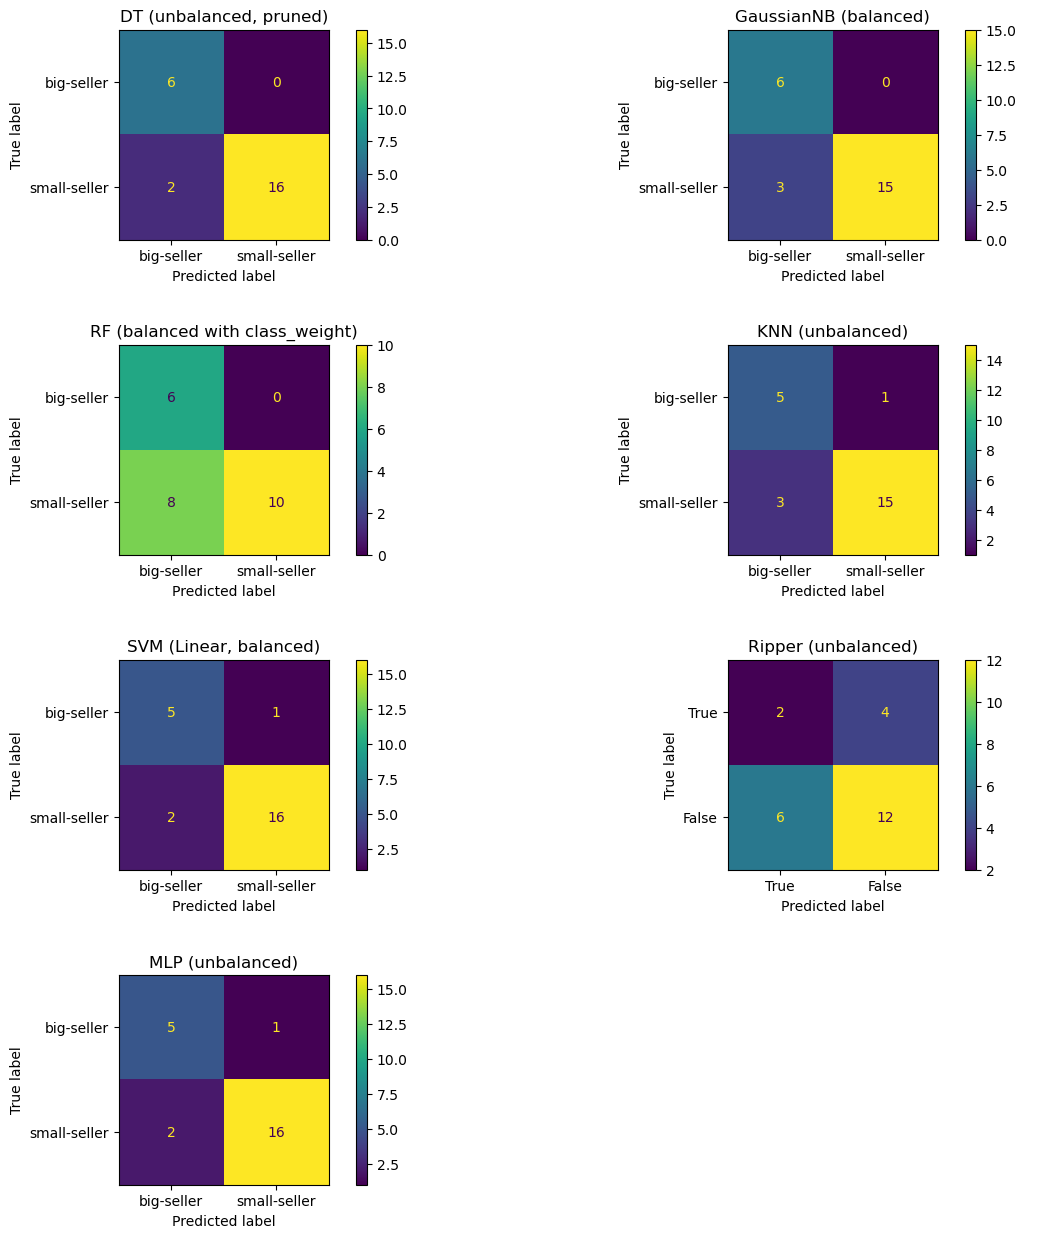

In [109]:
n_models = len(model_dict)
fig, axes = plt.subplots(nrows=(n_models+1)//2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

pos = 0
for k,v in model_dict.items():
    
    row_id = pos//2
    col_id = pos%2
    
    cur_title = k
    cur_model = v
    
    axes[row_id][col_id].set_title(cur_title)
    
    if cur_model != ripper_unb:
        plot_confusion_matrix(cur_model, test_set, test_label, ax=axes[row_id][col_id])
    else:
        plot_confusion_matrix(cur_model, test_set, test_label_rip, ax=axes[row_id][col_id], labels=(True, False))
    
    pos += 1
    
    if pos == n_models:
        axes[pos//2][pos%2].axis("off")

plt.show() 

### Conclusions
GaussianNB and the decision tree are the only models able to correctly detect all big-sellers, however they classify some small-sellers as big-sellers.  
None of the classifiers tested has a perfect score.

## Bonus XAI
We will take another look at the SVM, RF and MLP best performing models with the tools included in the "dalex" library.

In [110]:
test_label_exp = test_label.replace({"big-seller":1, "small-seller":0})

While sklearn encodes the target values to numbers on its own dalex needs help.

In [127]:
exp_rf = dx.Explainer(rf_bal, test_set, test_label_exp)
exp_svm = dx.Explainer(svm_lin_bal, test_set, test_label_exp)
exp_mlp = dx.Explainer(mlp_unb, test_set, test_label_exp)

Preparation of a new explainer is initiated

  -> data              : 24 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 24 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f52c7bc5a60> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.184, mean = 0.601, max = 0.968
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.968, mean = -0.351, max = 0.816
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 24 rows 11 cols
  -> target variable   : Paramet

### Global explanations

#### Variable importance

In [128]:
mp_rf = exp_rf.model_parts()
mp_rf.plot()

In [125]:
mp_svm = exp_svm.model_parts()
mp_svm.plot()

In [129]:
mp_mlp = exp_mlp.model_parts()
mp_mlp.plot()

#### Partial dependence profile

In [137]:
rf_mprofile_group = exp_rf.model_profile(type = "partial")
rf_mprofile_group.plot()

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 49.09it/s]


In [138]:
svm_mprofile_group = exp_svm.model_profile(type = "partial")
svm_mprofile_group.plot()

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 77.48it/s]


In [139]:
mlp_mprofile_group = exp_mlp.model_profile(type = "partial")
mlp_mprofile_group.plot()

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 69.12it/s]


## TODO
- add dalex xai code
- write conclusions
- check SMOTE algorithm